## Search of Kernel Polynomials for Gaussian Process Regression Modeling of Small Datasets

### [Alessio Tamburro](https://alessiot.github.io/dsprojects/)
<br>

**The source code for this article is available [here](https://github.com/alessiot/polygp-sklearn)**
<br>

**Data and more info on the subject [here](https://gml.noaa.gov/ccgg/trends/)**
<br>

*Note: the html version of this notebook was created with [nbconvert](https://nbconvert.readthedocs.io/en/latest/config_options.html) and running the command jupyter nbconvert --to html --TagRemovePreprocessor.remove_input_tags="notvisible" notebook.ipynb. A tag "notvisible" was added to the cells that are not displayed in this rendered html*
<br>


In this study, we want to forecast the monthly average atmospheric $CO_2$ concentrations (in parts per million by volume (ppm)) collected at the Mauna Loa Observatory in Hawaii. The dataset used for this study spans the period between 1958 and 2001. 
The goal is to train a model of the $CO_2$ concentration as a function of the time for the data collected until 2001 and extracpolate for the following years until today. A similar study is available from the book of [Carl E. Rasmussen and Christopher K.I. Williams, “Gaussian Processes for Machine Learning”, MIT Press 2006](https://www.gaussianprocess.org/gpml/chapters/RW.pdf) and has been [demonstrated](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_co2.html) using the Python library of *scikit-learn* for Gaussian Process regression [gaussian_process](https://github.com/scikit-learn/scikit-learn/tree/3f89022fa04d293152f1d32fbc2a5bdaaf2df364/sklearn/gaussian_process).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, Matern, WhiteKernel, Kernel, DotProduct, RationalQuadratic

from mapie.regression import MapieRegressor

import matplotlib.pyplot as plt

from typing import List, Callable, Dict, Tuple, Union, Optional


from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder


from copy import deepcopy

import plotly.graph_objects as go

import plotly.io as pio
import warnings
from sklearn.exceptions import ConvergenceWarning

# raise error if convergence warning is issued so that we can try/except it
warnings.filterwarnings("error", category = ConvergenceWarning)

from scipy.spatial import distance


#from polygp_optuna_1 import train_gp, calculate_bic, calculate_num_params

try:
    import polygp
    from polygp import train_gp, _calculate_bic, _calculate_num_params, build_poly_kernel
except ImportError as e:
    # this is needed if you decide not to install polygp 
    import sys
    sys.path.append('../')    
    from polygp.src.polygp import train_gp, _calculate_bic, _calculate_num_params, build_poly_kernel



In [209]:
## Workaround to display Latex formula in plotly
plotly.offline.init_notebook_mode()
display(HTML(
    '<script type="text/javascript" async src="https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.1/MathJax.js?config=TeX-MML-AM_SVG"></script>'
))
##


In [32]:
## functions to move

def generate_grid(exp_space: dict = {}, 
                  num_samples: int = 10,
                  random_state: int = 1) -> np.ndarray:
    rng = np.random.RandomState(random_state)    
    rnd_samples = []
    while len(rnd_samples) < num_samples:
        # Generate random values
        rnd_dict = {
            c_i: rng.uniform(exp_space[c_i]['values'][0],exp_space[c_i]['values'][1])\
                if exp_space[c_i]['val_type']=='float'\
                else rng.choice(exp_space[c_i]['values'])\
                for c_i in exp_space if exp_space[c_i]['cl']=='inp'
        }
        rnd_samples.append(rnd_dict)

    # 2D array
    rnd_samples = pd.DataFrame(rnd_samples).values

    return rnd_samples

def generate_data(exp_space, generating_fun, num_samples = 1_000, random_state=1):

    # Sampling the process space
    X = generate_grid(exp_space, num_samples = num_samples,
                      random_state = random_state) 
    # True generative process function
    Z = generating_fun(X)

    return X, Z

def select_training_data(X, Z, exp_space, generating_fun, is_error=False, training_size=10, random_state=1):

    rng = np.random.RandomState(random_state) 

    # Sample training data indices
    training_indices = rng.choice(np.arange(Z.size), size=training_size, replace=False)
    X_train, Z_train = X[training_indices], Z[training_indices]
    X_noise_std, Z_noise_std = None, None
    if is_error:
        ## we observe at the location identified by the training indices and measure the X_train values with uncertainty values X_noise_std
        X_train = X[training_indices]
        X_noise_std = np.array([exp_space['X1']['err']]*len(X_train)).reshape(-1,1) #* abs(X_train)
        ## ...but due to the uncertainty in X, Z = f(X+X_noise)
        X_noise = [rng.normal(loc=0.0, scale=xn, size=1) for xn in X_noise_std]
        Z_train = generating_fun(X_train+X_noise)
        ## and on top of it we have uncertainty in the measurement of Z
        Z_noise_std = np.array([exp_space['Z']['err']]*len(Z_train)).reshape(-1,1) #* abs(Z_train)
        Z_noise = [rng.normal(loc=0.0, scale=zn, size=1) for zn in Z_noise_std]
        Z_train += Z_noise
    
    return X_train, Z_train, X_noise_std, Z_noise_std 

def fit_model_(X_train, 
              Z_train, 
              kernel, 
              optimizer, 
              max_retries = 20):


    opti_msg = 'Training kernel - kernel will change' if optimizer else 'Refitting - kernel will not change'
    print(f"Fitting with kernel: {kernel}. {opti_msg}")
    gaussian_process = GaussianProcessRegressor()
    ## recover numerical issues
    for r_i in range(1, max_retries+1):
        try:
            gaussian_process = GaussianProcessRegressor(kernel=kernel,
                                                        optimizer=optimizer,
                                                        n_restarts_optimizer=10)
            gaussian_process.fit(X_train, Z_train)
            break
        except Exception as e:
            # Handle the exception 
            print(f"retry: {r_i} - Operation failed with warning: {e}")
    else:
        # This block runs if the loop completes without a successful operation
        print("Maximum retries reached, operation failed.")
    ###
    llh_current = gaussian_process.log_marginal_likelihood_value_
    kernel_current = gaussian_process.kernel_

    return gaussian_process, llh_current, kernel_current

def fit_model(train_df, 
              num_lst,
              cat_lst,
              inp_lst,
              out_lst,
              kernel, 
              optimizer, 
              max_retries = 20):

    # preprocessing pipeline
    ppl_pre = []
    cat_proc = OneHotEncoder(handle_unknown="ignore", 
                            sparse=False, 
                            drop='if_binary') 
    num_proc = StandardScaler()#PowerTransformer('yeo-johnson', standardize=True)
    ppl_pre.append(
        ColumnTransformer(
            transformers=[
                ('one-hot-encoder', cat_proc, cat_lst), 
                ('scaler', num_proc, num_lst), 
            ],
            remainder='passthrough', # selection of inputs happen during fit anyway
        )
    )  

    # random state: should we fix it as well, maybe with a different number?
    gpr = GaussianProcessRegressor(
        optimizer=optimizer, 
        n_restarts_optimizer = 10,
        kernel=kernel,
    )

    # append to pipeline
    ppl_pre.append(gpr)      
    # create pipeline
    ppl = make_pipeline(*ppl_pre)

    opti_msg = 'Training kernel - kernel will change' if optimizer else 'Refitting - kernel will not change'
    print(f"Fitting with kernel: {kernel}. {opti_msg}")
    gaussian_process = GaussianProcessRegressor()
    ## recover numerical issues
    for r_i in range(1, max_retries+1):
        try:
            ppl.fit(train_df[inp_lst], train_df[out_lst])
            break
        except Exception as e:
            # Handle the exception 
            print(f"retry: {r_i} - Operation failed with warning: {e}")
    else:
        # This block runs if the loop completes without a successful operation
        print("Maximum retries reached, operation failed.")
    ###
    llh_current = ppl[-1].log_marginal_likelihood_value_
    kernel_current = ppl[-1].kernel_

    return ppl, llh_current, kernel_current

def create_gp_regression_plot_(X_true, Z_true, X_obs, Z_obs, Z_true_preds, Z_std_preds, ix=0, zx=0):
    '''Plot the true values, the observed values and the predicted values
    '''

    # Make sure values are sorted before plotting
    sorted_indices = np.argsort(X_true[:,ix])

    lower_bound = Z_true_preds[sorted_indices,zx] - 1.96 * Z_std_preds[sorted_indices,zx]
    upper_bound = Z_true_preds[sorted_indices,zx] + 1.96 * Z_std_preds[sorted_indices,zx]
    plt.plot(X_true[sorted_indices,ix], Z_true[sorted_indices,zx], label=r"True function", linestyle="dotted")
    plt.scatter(X_obs[:,ix], Z_obs[:,zx], label="Observations")
    plt.plot(X_true[sorted_indices,ix], Z_true_preds[sorted_indices,zx], label="Mean prediction")
    plt.fill_between(
        X_true[sorted_indices,ix].ravel(),
        lower_bound,
        upper_bound,
        alpha=0.5,
        label=r"95% confidence interval",
    )
    plt.ylim([np.min([Z_true[:,zx], upper_bound]), np.max([Z_true[:,zx], upper_bound])])
    plt.legend()
    plt.xlabel("$x$")
    plt.ylabel("$f(x)$")
    _ = plt.title("Gaussian process regression")
    return plt

def create_gp_regression_plot(X_true, Z_true, X_obs, Z_obs, dX_obs, dZ_obs, Z_true_preds, Z_std_preds, text_display = '', ix=0, zx=0):    
    '''Plot the true values, the observed values, and the predicted values using Plotly
    '''

    # Make sure values are sorted before plotting
    sorted_indices = np.argsort(X_true[:,ix])

    fig = go.Figure()

    # Plot the true function
    fig.add_trace(go.Scatter(
        name="True function", 
        showlegend=True,
        x=X_true[sorted_indices,ix], y=Z_true[sorted_indices,zx],
        mode='lines', 
        line=dict(dash='dash'),
        line_color='rgba(0, 0, 255, 1)',
        #error_x=dict(type='data', array=error_x, visible=True),
        #error_y=dict(type='data', array=noise_level*df[sq.out_lst[0]], visible=True if noise_level>0 else False),    
    ))

    # Plot the observed values
    fig.add_trace(go.Scatter(
        name="Observations", 
        x=X_obs[:,ix], y=Z_obs[:,zx],
        error_y=dict(
            type='data',  # Error type (data or constant)
            array=dZ_obs[:, zx],  # Array of error values
            visible=True,
            color='rgba(255, 165, 0)',  # Color of error bars
        ) if type(dZ_obs)==np.ndarray else None,
        error_x=dict(
            type='data',  # Error type (data or constant)
            array=dX_obs[:,ix],  # Array of error values
            visible=True,
            color='rgba(255, 165, 0)',  # Color of error bars
        ) if type(dX_obs)==np.ndarray else None,
        mode='markers', 
        marker=dict(size=8),
        marker_color = 'rgba(255, 165, 0)',
        #error_x=dict(type='data', array=error_x, visible=True),
        #error_y=dict(type='data', array=noise_level*df[sq.out_lst[0]], visible=True if noise_level>0 else False),    
        showlegend=True,
    ))

    # Plot the mean prediction
    fig.add_trace(go.Scatter(
        name="Mean prediction",
        showlegend=True,
        x=X_true[sorted_indices,ix], y=Z_true_preds[sorted_indices,zx],
        mode='lines', 
        line_color='rgba(0, 128, 0, 1)',
        #line=dict(dash='dash'),
        #error_x=dict(type='data', array=error_x, visible=True),
        #error_y=dict(type='data', array=noise_level*df[sq.out_lst[0]], visible=True if noise_level>0 else False),    
    ))

    # Create confidence interval shading
    upper_bound = Z_true_preds[sorted_indices,zx] + 1.96 * Z_std_preds[sorted_indices,zx]
    lower_bound = Z_true_preds[sorted_indices,zx] - 1.96 * Z_std_preds[sorted_indices,zx]
    fig.add_trace(go.Scatter(
        name="95% C.I. Lower Bound",
        x=X_true[sorted_indices,ix],
        y=lower_bound,
        line_color='rgba(0, 128, 0, 1)',
        #line=dict(width=1, shape='spline'),
    ))
    fig.add_trace(go.Scatter(
        name="95% C.I. Upper Bound",
        x=X_true[sorted_indices,ix],
        y=upper_bound,
        fill="tonexty",
        fillcolor='rgba(0, 128, 0, 0.2)',
        line_color='rgba(0, 128, 0, 1)',
        #line=dict(width=1, shape='spline'),
    ))

    # Update layout
    fig.update_layout(
        #title="Gaussian process regression",
        xaxis_title=f"X({ix})" if X_true.shape[1]>1 else 'X',
        yaxis_title=f"Y({zx})" if Z_true.shape[1]>1 else 'Z',
        showlegend=True,
        plot_bgcolor='white', 
        paper_bgcolor='white',
        yaxis_range = [np.min(Z_true[:,zx]), np.max(Z_true[:,zx])],   
        xaxis_range = [np.min(X_true[:,ix]), np.max(X_true[:,ix])]    
    )

    # Add a text box below the legend
    fig.update_layout(
        annotations=[
            dict(
                x=0,
                y=max(Z_true),
                xref="paper",
                yref="paper",
                text=text_display,
                showarrow=False,
                font=dict(size=15),
            )
        ]
    )

    return fig

def get_minmax(X_rnd, X, k_points):
    """Given an existing 2D array X of N m-dimensional points (N, m), and an array X_rnd of S randomly sampled
    m-dimensional points (S, m), select k_points from X_rnd that satisy the maxmin property
    """

    # Calculate distances between each random additional point in X_rnd and each existing point in X
    cdistances = distance.cdist(X_rnd, X, metric='euclidean') # dist(u=XA[i], v=XB[j])

    # Take min distance of each random point to each existing point
    cdistances_min = cdistances.min(axis=1) 

    # Take max of all the min distances
    cdistances_idx_max = np.argpartition(cdistances_min, -k_points)[-k_points:]

    return cdistances_idx_max, X_rnd[cdistances_idx_max]

def generate_samples(X, exp_space, num_samples=1000, k_points=1, random_state = 1):
    """Given an existing 2D array of N m-dimensional points (N, m), return k additional points 
    that satisfy the maxmin condition 
    """
    print(f'Generating {num_samples} in {exp_space}')
    # generate random samples to select from based on minmax later
    rnd_samples = generate_grid(exp_space, num_samples, random_state)

    _, sel_rnd_samples = get_minmax(rnd_samples, X, k_points)

    #print(f'Selected points have coordinates {sel_rnd_samples}')

    return sel_rnd_samples

def sequential_training_1(exp_space: dict = {},
                        use_error: bool = False,
                        generating_func: Callable = lambda x: 1,
                        init_training_size: int = 10, 
                        add_training_size: int = 1,
                        end_training_size: int = 30,
                        init_kernel: Kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-5, 1e5)), 
                        random_state: int = 1, 
                        graph_path: str = '') -> dict:  # type: ignore
    """This function performs sequential training of a Gaussian Process model
    inputs:

        X: 
            numpy array with the input data from the true generative process (2D array)
        Z:
            numpy array with the output data from the true generative process (2D array)
        init_training_size:
            initial number of data rows
        add_training_size:
            additional number of data rows at each iteration
        end_training_size:
            final number of data rows
        random_state:
            seed for training data sampling
        save_graphs:
            if provided, graphs will be saved at this location

    outputs:
        dictionary storing the results at each iteration
    """

    results_dict = {}

    # Randomly sample true function in design space and select training samples
    training_size = init_training_size
    X, Z = generate_data(exp_space, generating_func, num_samples = 1_000, random_state=random_state)
    X_train, Z_train, X_noise_std, Z_noise_std = select_training_data(X, Z, exp_space, 
                                                                      generating_func, 
                                                                      is_error=use_error, 
                                                                      training_size=training_size, 
                                                                      random_state=random_state)
    # create data frame to handle pipelines
    inp_lst = [ii for ii, jj in exp_space_dict.items() if jj['cl'] == 'inp'] 
    out_lst = [ii for ii, jj in exp_space_dict.items() if jj['cl'] == 'out'] 
    num_lst = [ii for ii in inp_lst if exp_space_dict[ii]['val_type'] == 'float'] 
    cat_lst = [ii for ii in inp_lst if exp_space_dict[ii]['val_type'] == 'object'] 
    train_df = pd.DataFrame(np.concatenate([X_train,Z_train], axis=1), columns=inp_lst+out_lst)
    generated_df = pd.DataFrame(np.concatenate([X,Z], axis=1), columns=inp_lst+out_lst) 
    # fit initial model
    gaussian_process, llh_current, kernel_current = fit_model(train_df, 
                                                              num_lst, cat_lst,
                                                              inp_lst, out_lst, 
                                                              init_kernel, 
                                                              optimizer='fmin_l_bfgs_b')
    # predictions for the whole set
    mean_prediction, std_prediction = gaussian_process.predict(generated_df[inp_lst], return_std=True)
    mean_prediction = mean_prediction.reshape(-1,1)
    std_prediction = std_prediction.reshape(-1,1)
    mse_all = mean_squared_error(generated_df[out_lst], mean_prediction)
    r2_all = r2_score(generated_df[out_lst], mean_prediction)
    print(f"Initial GPR --- training size: {init_training_size}, kernel: {kernel_current}, llh: {llh_current}, r2: {r2_all}, 'mse: {mse_all}")
    # store results
    results_dict['training_size'] = [init_training_size]
    results_dict['llh'] = [llh_current]
    results_dict['r2'] = [r2_all]
    results_dict['mse'] = [mse_all]
    results_dict['kernel'] = [kernel_current]

    if graph_path!='':
        cnt = 0
        gp_plot = create_gp_regression_plot(X, Z, X_train, Z_train, X_noise_std, Z_noise_std,
                                            mean_prediction, std_prediction, 
                                            f"training size: {training_size}; llh: {np.round(llh_current,3)}; mse: {np.round(mse_all,3)}")
        pio.write_image(gp_plot, f"{graph_path}/graph_{str(cnt)}.png")


    rng = np.random.RandomState(random_state) # for error

    # increase data
    n_iter = int((end_training_size - init_training_size)/add_training_size)
    print(f"Running {n_iter} iterations with {add_training_size} additiona points")
    for cnt in range(1, n_iter+1):
        # Sample new training points 
        X_idx_new, X_new = get_minmax(X, X_train, add_training_size)
        Z_new = Z[X_idx_new,:]
        # add error if requested
        X_new_noise_std, Z_new_noise_std = None, None
        if use_error:
            X_new_noise_std = np.array([exp_space['X1']['err']]*len(X_new)).reshape(-1,1) 
            ## ...but due to the uncertainty in X, Z = f(X+X_noise)
            X_new_noise = [rng.normal(loc=0.0, scale=xn, size=1) for xn in X_new_noise_std]
            Z_new = generating_func(X_new+X_new_noise)
            ## and on top of it we have uncertainty in the measurement of Z
            Z_new_noise_std = np.array([exp_space['Z']['err']]*len(Z_new)).reshape(-1,1) 
            Z_new_noise = [rng.normal(loc=0.0, scale=zn, size=1) for zn in Z_new_noise_std]
            Z_new += Z_new_noise
            X_noise_std = np.concatenate([X_noise_std,X_new_noise_std], axis=0)
            Z_noise_std = np.concatenate([Z_noise_std,Z_new_noise_std], axis=0)

        X_train = np.concatenate([X_train,X_new], axis=0)
        Z_train = np.concatenate([Z_train,Z_new], axis=0)
        # try to fit on new data without changing the kernel
        train_df = pd.DataFrame(np.concatenate([X_train,Z_train], axis=1), columns=inp_lst+out_lst)
        gaussian_process, llh_tmp_1, kernel_tmp = fit_model(train_df, num_lst, cat_lst,
                                                            inp_lst, out_lst, 
                                                            kernel_current, optimizer=None)

        # do we need to retrain? Yes, if llh is worse (smaller)
        llh_tmp = llh_tmp_1
        if llh_tmp_1 < llh_current:
            print(f'---> llh is smaller than previous one: {llh_tmp_1}; retraining')
            gaussian_process, llh_tmp_2, kernel_tmp = fit_model(train_df, num_lst, cat_lst,
                                                                inp_lst, out_lst, 
                                                                kernel_current, optimizer='fmin_l_bfgs_b')
            llh_tmp = llh_tmp_2
            # ... but if retraining gives worse results...
            if llh_tmp_2 < llh_tmp_1:
                print(f'---> retraining did not work, llh: {llh_tmp_2}; going back')
                gaussian_process, llh_tmp_3, kernel_tmp = fit_model(train_df, num_lst, cat_lst,
                                                                    inp_lst, out_lst, 
                                                                    kernel_current, optimizer=None)
                llh_tmp = llh_tmp_3
            ####
        llh_current = llh_tmp
        kernel_current = kernel_tmp
        # predictions for the whole set
        mean_prediction, std_prediction = gaussian_process.predict(generated_df[inp_lst], return_std=True)
        mean_prediction = mean_prediction.reshape(-1,1)
        std_prediction = std_prediction.reshape(-1,1)
        mse_all = mean_squared_error(generated_df[out_lst], mean_prediction)
        r2_all = r2_score(generated_df[out_lst], mean_prediction)

        training_size = len(X_train)

        print(f"GPR --- training size: {training_size}, llh: {llh_current}, r2: {r2_all}, 'mse: {mse_all}, kernel: {kernel_current},")

        results_dict['training_size'].append(training_size)
        results_dict['llh'].append(llh_current)
        results_dict['r2'].append(r2_all)
        results_dict['mse'].append(mse_all)
        results_dict['kernel'].append(kernel_current)

        if graph_path!='':
            #gp_plot = create_gp_regression_plot_(X, Z, X_train, Z_train, mean_prediction, std_prediction)
            #_ = gp_plot.title(f"training size: {training_size}; llh: {np.round(llh_current,3)}; mse: {np.round(mse_all,3)}")
            #print(f"{graph_path}/graph_{str(cnt)}.png")
            #gp_plot.savefig(f"{graph_path}/graph_{str(cnt)}.png")
            #gp_plot.close()
            gp_plot = create_gp_regression_plot(X, Z, X_train, Z_train, X_noise_std, Z_noise_std,
                                                mean_prediction, std_prediction, 
                                                f"training size: {training_size}; llh: {np.round(llh_current,3)}; mse: {np.round(mse_all,3)}")
            pio.write_image(gp_plot, f"{graph_path}/graph_{str(cnt)}.png")

    return results_dict

def plot_results(res_dict, text_display=''):

    fig = go.Figure()

    fig.add_trace(go.Scatter(
        name="Log-likelihood", 
        x=res_dict['training_size'], 
        y=res_dict['llh'],
        yaxis='y',
        mode='lines', 
        line=dict(dash='dash'),
        line_color='rgba(0, 0, 255, 1)',
        showlegend=True,
    ))

    fig.add_trace(go.Scatter(
        name="R2", 
        x=res_dict['training_size'], 
        y=res_dict['r2'],
        yaxis='y2',
        mode='lines', 
        marker=dict(size=8),
        line_color = 'rgba(255, 165, 0)',
        showlegend=True,
    ))

    #fig.add_trace(go.Scatter(
    #    name="MSE", 
    #    x=res_dict['training_size'], 
    #    y=res_dict['mse'],
    #    yaxis='y2',
    #    mode='lines', 
    #    marker=dict(size=8),
    #    line_color='rgba(0, 128, 0, 1)',
    #    showlegend=True,
    #))

    # Update layout
    fig.update_layout(
        #title=f'Model Performance {text_display}',
        #title_font=dict(size=30, ),
        xaxis_title=f"Training size",
        yaxis_title=f"Peformance (on true unknown function)",
        showlegend=True,
        plot_bgcolor='white', 
        paper_bgcolor='white',
        yaxis=dict(title='Log-likelihood', side='left', showgrid=False),
        yaxis2=dict(title='R2', side='right', overlaying='y', showgrid=False),
        #yaxis_range = [min(Z_true[:,zx]), max(Z_true[:,zx])],   
        #xaxis_range = [min(X_true[:,ix]), max(X_true[:,ix])]    
    )

    # Add a text box below the legend
    #fig.update_layout(
    #    annotations=[
    #        dict(
    #            x=np.mean(res_dict['training_size']),
    #            y=np.min(res_dict['llh']),
    #            xref="x",
    #            yref="y",
    #            text=f"Final Kernel: {str(res_dict['kernel'][-1])}",
    #            showarrow=False,
    #            font=dict(size=10),
    #        )
    #    ]
    #)



    return fig

def sequential_training(exp_space: dict = {},
                        use_error: bool = False,
                        generating_func: Callable = lambda x: 1,
                        init_training_size: int = 10, 
                        add_training_size: int = 1,
                        end_training_size: int = 30,
                        random_state: int = 1, 
                        graph_path: str = '') -> dict:  # type: ignore
    """This function performs sequential training of a Gaussian Process model
    inputs:

        X: 
            numpy array with the input data from the true generative process (2D array)
        Z:
            numpy array with the output data from the true generative process (2D array)
        init_training_size:
            initial number of data rows
        add_training_size:
            additional number of data rows at each iteration
        end_training_size:
            final number of data rows
        random_state:
            seed for training data sampling
        save_graphs:
            if provided, graphs will be saved at this location

    outputs:
        dictionary storing the results at each iteration
    """

    results_dict = {}

    # Randomly sample true function in design space and select training samples
    training_size = init_training_size
    X, Z = generate_data(exp_space, generating_func, num_samples = 1_000, random_state=random_state)
    X_train, Z_train, X_noise_std, Z_noise_std = select_training_data(X, Z, exp_space, 
                                                                      generating_func, 
                                                                      is_error=use_error, 
                                                                      training_size=training_size, 
                                                                      random_state=random_state)
    # create data frame to handle pipelines
    inp_lst = [ii for ii, jj in exp_space.items() if jj['cl'] == 'inp'] 
    out_lst = [ii for ii, jj in exp_space.items() if jj['cl'] == 'out'] 
    num_lst = [ii for ii in inp_lst if exp_space[ii]['val_type'] == 'float'] 
    cat_lst = [ii for ii in inp_lst if exp_space[ii]['val_type'] == 'object'] 
    train_df = pd.DataFrame(np.concatenate([X_train,Z_train], axis=1), columns=inp_lst+out_lst)
    generated_df = pd.DataFrame(np.concatenate([X,Z], axis=1), columns=inp_lst+out_lst) 
    # fit initial model - find best kernel - llh is bic (the smaller the better)
    gaussian_process, llh_current, kernel_current, study = train_gp(train_df, inp_lst, out_lst,
                                                             cat_lst, num_lst,
                                                             max_evals=1000, early_stopping_rounds=200,
                                                             model_complexity = {'max_n_prod': 2, 'min_n_prod_terms': 4, 'comb_type': 'worepl'}
                                                             )
    # predictions for the whole set
    mean_prediction, std_prediction = gaussian_process.predict(generated_df[inp_lst], return_std=True)
    mean_prediction = mean_prediction.reshape(-1,1)
    std_prediction = std_prediction.reshape(-1,1)
    mse_all = mean_squared_error(generated_df[out_lst], mean_prediction)
    r2_all = r2_score(generated_df[out_lst], mean_prediction)
    print(f"Initial GPR --- training size: {init_training_size}, llh: {llh_current}, r2: {r2_all}, 'mse: {mse_all}, kernel: {kernel_current},")
    # store results
    results_dict['training_size'] = [init_training_size]
    results_dict['llh'] = [llh_current]
    results_dict['r2'] = [r2_all]
    results_dict['mse'] = [mse_all]
    results_dict['kernel'] = [kernel_current]

    if graph_path!='':
        cnt = 0
        gp_plot = create_gp_regression_plot(X, Z, X_train, Z_train, X_noise_std, Z_noise_std,
                                            mean_prediction, std_prediction, 
                                            f"training size: {training_size}; llh: {np.round(llh_current,3)}; mse: {np.round(mse_all,3)}; r2: {np.round(r2_all,3)}")
        pio.write_image(gp_plot, f"{graph_path}/graph_{str(cnt)}.png")

    rng = np.random.RandomState(random_state) # for error

    # increase data
    n_iter = int((end_training_size - init_training_size)/add_training_size)
    above_thr = 0
    print(f"Running {n_iter} iterations with {add_training_size} additional points")
    for cnt in range(1, n_iter+1):
        # Sample new training points 
        X_idx_new, X_new = get_minmax(X, X_train, add_training_size)
        Z_new = Z[X_idx_new,:]
        # add error if requested
        X_new_noise_std, Z_new_noise_std = None, None
        if use_error:
            X_new_noise_std = np.array([exp_space['X1']['err']]*len(X_new)).reshape(-1,1) 
            ## ...but due to the uncertainty in X, Z = f(X+X_noise)
            X_new_noise = [rng.normal(loc=0.0, scale=xn, size=1) for xn in X_new_noise_std]
            Z_new = generating_func(X_new+X_new_noise)
            ## and on top of it we have uncertainty in the measurement of Z
            Z_new_noise_std = np.array([exp_space['Z']['err']]*len(Z_new)).reshape(-1,1) 
            Z_new_noise = [rng.normal(loc=0.0, scale=zn, size=1) for zn in Z_new_noise_std]
            Z_new += Z_new_noise
            X_noise_std = np.concatenate([X_noise_std,X_new_noise_std], axis=0)
            Z_noise_std = np.concatenate([Z_noise_std,Z_new_noise_std], axis=0)

        X_train = np.concatenate([X_train,X_new], axis=0)
        Z_train = np.concatenate([Z_train,Z_new], axis=0)
        # Fit with initial history
        train_df = pd.DataFrame(np.concatenate([X_train,Z_train], axis=1), columns=inp_lst+out_lst)
        gaussian_process, llh_current, kernel_current, study = train_gp(train_df, inp_lst, out_lst,
                                                        cat_lst, num_lst,
                                                        max_evals=1000, early_stopping_rounds=200, 
                                                        model_complexity = {'max_n_prod': 2, 'min_n_prod_terms': 4, 'comb_type': 'worepl'},
                                                        study_init=study
                                                    )
        # predictions for the whole set
        mean_prediction, std_prediction = gaussian_process.predict(generated_df[inp_lst], return_std=True)
        mean_prediction = mean_prediction.reshape(-1,1)
        std_prediction = std_prediction.reshape(-1,1)
        mse_all = mean_squared_error(generated_df[out_lst], mean_prediction)
        r2_all = r2_score(generated_df[out_lst], mean_prediction)
        
        training_size = len(X_train)

        print(f"GPR --- training size: {training_size}, llh: {llh_current}, r2: {r2_all}, 'mse: {mse_all}, kernel: {kernel_current},")

        results_dict['training_size'].append(training_size)
        results_dict['llh'].append(llh_current)
        results_dict['r2'].append(r2_all)
        results_dict['mse'].append(mse_all)
        results_dict['kernel'].append(kernel_current)

        if graph_path!='':
            gp_plot = create_gp_regression_plot(X, Z, X_train, Z_train, X_noise_std, Z_noise_std,
                                                mean_prediction, std_prediction, f"training size: {training_size}; llh: {np.round(llh_current,3)}; mse: {np.round(mse_all,3)}; r2: {np.round(r2_all,3)}"
                                                )
            pio.write_image(gp_plot, f"{graph_path}/graph_{str(cnt)}.png")

        if r2_all >= 0.98:
            above_thr += 1
        else:
            above_thr = 0
        
        # if 3 above 98% in a row, break
        if above_thr>=5:
            break

    return results_dict


## Benchmark Functions

We will utilize some of the bemchmark functions used when trying to evaluate optimization algorithms. A longer list of functions is available from [SFU](https://www.sfu.ca/~ssurjano/optimization.html).

# Gaussian Process Regression: Brief Intro

Use sphere function to show kernel and things as an introduction and save main functions

Steps:
We assume there is a generative process or some sort of true function that describes the underlying process.
training sample


In [24]:
# Design space
exp_space_dict = {'X1' : {'values' : [-2,2], 'val_type': 'float', 'cl': 'inp', 'err': 0}, 
                  'Z': {'values': [0, 1], 'val_type': 'float', 'cl': 'out', 'err': 0}} 

# True generative process function
#sphere_b = lambda x_in, x_min: np.square(x_in - x_min).sum(axis=1).reshape(-1,1)
#dropwave_b = lambda x_in, x_min: (-(1.0 + np.cos(12 * np.sqrt(np.square(x_in-x_min).sum(axis=1))))/((1.0/len(x_min))*np.square(x_in-x_min).sum(axis=1) + 2)).reshape(-1,1)
sphere_b = lambda x_in: np.square(x_in).sum(axis=1).reshape(-1,1)
dropwave_b = lambda x_in: (-(1.0 + np.cos(12 * np.sqrt(np.square(x_in).sum(axis=1))))/((1.0/len(x_in))*np.square(x_in).sum(axis=1) + 2)).reshape(-1,1)
#poly_b = lambda x_in, x_min, coeffs: np.sum([cf * np.power(x_in - x_min, ep+1) for ep, cf in enumerate(coeffs)], axis=0).reshape(-1,1)
#test_b = lambda x_in, x_min: (np.power(x_in - x_min, 1) * np.sin(x_in)).reshape(-1,1)

X, Z = generate_data(exp_space_dict, dropwave_b, num_samples = 1_000, random_state=1)

X_train, Z_train, X_noise_std, Z_noise_std = select_training_data(X, Z, exp_space_dict, dropwave_b, is_error=False, training_size=10, random_state=1)

#Z = poly_b(X, [0], [5, -5, 0, 0, -1])
#Z = test_b(X, [0]) # 0, 10

In [25]:
# The dataframe with the observations - typically this is what we expect
train_df = pd.DataFrame(np.concatenate([X_train,Z_train], axis=1), columns=['X1','Z'])
train_df.head(3)

X1         Z
0 -1.259478 -0.085640
1  0.867083 -0.221497
2  1.623238 -0.903030

In [26]:
generated_df = pd.DataFrame(np.concatenate([X,Z], axis=1), columns=['X1','Z']) # remove training data from generated data

### Digression on Kernel

What is a kernel? Covariance... graph here

### GPR Model

In [27]:
init_kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-5, 1e5))
gaussian_process, llh, kernel = fit_model(train_df, ['X1'], [], ['X1'], ['Z'], init_kernel, optimizer="fmin_l_bfgs_b")

# kernel optimized with LLH
print(f"kernel: {kernel}")
print(f"llh: {llh}")
# predictions for the whole set
mean_prediction, std_prediction = gaussian_process.predict(generated_df[['X1']], return_std=True)
mean_prediction = mean_prediction.reshape(-1,1)
std_prediction = std_prediction.reshape(-1,1)

mse_all = mean_squared_error(generated_df[['Z']], mean_prediction)
r2_all = r2_score(generated_df[['Z']], mean_prediction)

print(f'r2: {r2_all}')   
print(f'mse: {mse_all}')  

Fitting with kernel: 1**2 * RBF(length_scale=1). Training kernel - kernel will change
kernel: 0.624**2 * RBF(length_scale=0.0998)
llh: -8.899513414028064
r2: -0.1345458092260312
mse: 0.1357916043187862


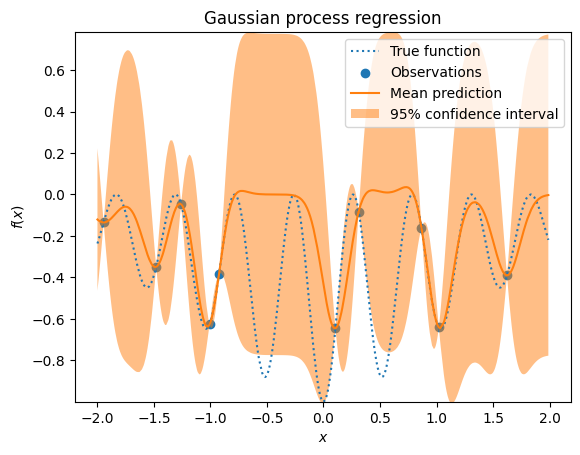

In [17]:
gp_plot = create_gp_regression_plot_(X, Z, X_train, Z_train, mean_prediction, std_prediction)

In [32]:
gp_plot = create_gp_regression_plot(X, Z, X_train, Z_train, X_noise_std, Z_noise_std, mean_prediction, std_prediction)

gp_plot

### Adding more points

We add more points based on maxmin and refit

In [69]:
# Generate new points from the true function based on maxmin
X_new = generate_samples(X_train, exp_space_dict, k_points=5)
Z_new = dropwave_b(X_new)
X_new = np.concatenate([X_train,X_new], axis=0)
Z_new = np.concatenate([Z_train,Z_new], axis=0)
train_df = pd.DataFrame(np.concatenate([X_new,Z_new], axis=1), columns=['X1','Z'])

# Fit the model without changing the kernel - no retraining
init_kernel = gaussian_process[-1].kernel_
gaussian_process, llh, kernel = fit_model(train_df, ['X1'], [], ['X1'], ['Z'], init_kernel, optimizer="fmin_l_bfgs_b")

# kernel optimized with LLH
print(f"kernel: {kernel}")
print(f"llh: {llh}")
# predictions for the whole set
mean_prediction, std_prediction = gaussian_process.predict(generated_df[['X1']], return_std=True)
mean_prediction = mean_prediction.reshape(-1,1)
std_prediction = std_prediction.reshape(-1,1)

mse_all = mean_squared_error(generated_df[['Z']], mean_prediction)
r2_all = r2_score(generated_df[['Z']], mean_prediction)

print(f'r2: {r2_all}')   
print(f'mse: {mse_all}')  

Generating 1000 in {'X1': {'values': [-2, 2], 'val_type': 'float', 'cl': 'inp', 'err': 0}, 'Z': {'values': [0, 1], 'val_type': 'float', 'cl': 'out', 'err': 0}}
Fitting with kernel: 0.44**2 * RBF(length_scale=1.23) * ExpSineSquared(length_scale=0.924, periodicity=0.901). Training kernel - kernel will change
kernel: 0.64**2 * RBF(length_scale=0.15) * ExpSineSquared(length_scale=991, periodicity=2.06e+04)
llh: 18.539429489740115
r2: -0.4392556450031968
mse: 0.110053892559972


In [21]:
gp_plot = create_gp_regression_plot(X, Z, X_new, Z_new, X_noise_std, Z_noise_std, mean_prediction, std_prediction)

gp_plot

### What if we increased the dataset size?

Try refit and measure llh. If llh drops, retrian



In [28]:
!rm ./graphs/*.png

exp_space_dict = {'X1' : {'values' : [-2,2], 'val_type': 'float', 'cl': 'inp', 'err': 0}, 
                  'Z': {'values': [0, 1], 'val_type': 'float', 'cl': 'out', 'err': 0}} 

res_dict = sequential_training_1(exp_space = exp_space_dict,
                               use_error = False,
                               generating_func=dropwave_b, 
                               init_training_size=10, 
                               add_training_size = 1, 
                               end_training_size = 30, 
                               init_kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-5, 1e5)), 
                               random_state = 1,
                               graph_path='./graphs')

Fitting with kernel: 1**2 * RBF(length_scale=1). Training kernel - kernel will change
Initial GPR --- training size: 10, kernel: 0.395**2 * RBF(length_scale=0.102), llh: -4.306638100132324, r2: -0.23973271548078912, 'mse: 0.09479720405911769
Running 20 iterations with 1 additiona points
Fitting with kernel: 0.395**2 * RBF(length_scale=0.102). Refitting - kernel will not change
---> llh is smaller than previous one: -5.28064297599315; retraining
Fitting with kernel: 0.395**2 * RBF(length_scale=0.102). Training kernel - kernel will change
GPR --- training size: 11, llh: -5.253344850092978, r2: 0.0250417681654711, 'mse: 0.07455100062959223, kernel: 0.413**2 * RBF(length_scale=0.109),
Fitting with kernel: 0.413**2 * RBF(length_scale=0.109). Refitting - kernel will not change
---> llh is smaller than previous one: -5.461887681076076; retraining
Fitting with kernel: 0.413**2 * RBF(length_scale=0.109). Training kernel - kernel will change
GPR --- training size: 12, llh: -5.412943130719627, r2

In [30]:
!ffmpeg -framerate 2 -i ./graphs/graph_%d.png -vf "palettegen" ./graphs/palette.png
!ffmpeg -framerate 2 -i ./graphs/graph_%d.png -i ./graphs/palette.png -lavfi "paletteuse" ./graphs/movie.gif

ffmpeg version 6.0 Copyright (c) 2000-2023 the FFmpeg developers
  built with Apple clang version 14.0.3 (clang-1403.0.22.14.1)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/6.0 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack --di

In [53]:
# TEST - REMOVE
exp_space_dict = {'X1' : {'values' : [-4,4], 'val_type': 'float', 'cl': 'inp', 'err': 0}, 
                  'Z': {'values': [0, 1], 'val_type': 'float', 'cl': 'out', 'err': 0}} 
f = lambda x, xm: (2*x**4 + x**2 + 2) / (x**4 + 1)
res_dict = sequential_training_1(exp_space = exp_space_dict,
                               use_error = False,
                               generating_func=f, 
                               init_training_size=10, 
                               add_training_size = 1, 
                               end_training_size = 30, 
                               init_kernel = 1 * RBF(), 
                               random_state = 1,
                               graph_path='./graphs')

Fitting with kernel: 1**2 * RBF(length_scale=1). Training kernel - kernel will change
Initial GPR --- training size: 10, kernel: 1.61**2 * RBF(length_scale=0.496), llh: -6.873795586984761, r2: -0.3178800758226905, 'mse: 0.02798576300933731
Running 20 iterations with 1 additiona points
Fitting with kernel: 1.61**2 * RBF(length_scale=0.496). Refitting - kernel will not change
---> llh is smaller than previous one: -11.100511843754013; retraining
Fitting with kernel: 1.61**2 * RBF(length_scale=0.496). Training kernel - kernel will change
GPR --- training size: 11, llh: -8.969817502269908, r2: -0.6165342705619756, 'mse: 0.03432781618174039, kernel: 1.62**2 * RBF(length_scale=0.455),
Fitting with kernel: 1.62**2 * RBF(length_scale=0.455). Refitting - kernel will not change
---> llh is smaller than previous one: -16.358147830927514; retraining
Fitting with kernel: 1.62**2 * RBF(length_scale=0.455). Training kernel - kernel will change
GPR --- training size: 12, llh: -10.414843886885848, r2: 

## A Better Assumption based on Domain Expert Knowledge

This will show it will need less data

In [61]:
exp_space_dict = {'X1' : {'values' : [-2,2], 'val_type': 'float', 'cl': 'inp', 'err': 0}, 
                  'Z': {'values': [0, 1], 'val_type': 'float', 'cl': 'out', 'err': 0}} 

res_dict = sequential_training_1(exp_space = exp_space_dict,
                               use_error = False,
                               generating_func=dropwave_b, 
                               init_training_size=10, 
                               add_training_size = 1, 
                               end_training_size = 30, 
                               init_kernel = 1 * RBF() * ExpSineSquared(), 
                               random_state = 1,
                               graph_path='./graphs')

Fitting with kernel: 1**2 * RBF(length_scale=1) * ExpSineSquared(length_scale=1, periodicity=1). Training kernel - kernel will change
Initial GPR --- training size: 10, kernel: 0.474**2 * RBF(length_scale=7.34) * ExpSineSquared(length_scale=1.19, periodicity=0.94), llh: 3.5267523395527487, r2: 0.38331077768531074, 'mse: 0.04715565969891523
Running 20 iterations with 1 additiona points
Fitting with kernel: 0.474**2 * RBF(length_scale=7.34) * ExpSineSquared(length_scale=1.19, periodicity=0.94). Refitting - kernel will not change
---> llh is smaller than previous one: -77.75919239494252; retraining
Fitting with kernel: 0.474**2 * RBF(length_scale=7.34) * ExpSineSquared(length_scale=1.19, periodicity=0.94). Training kernel - kernel will change
GPR --- training size: 11, llh: -5.251136149734261, r2: 0.016796463726094224, 'mse: 0.07518148476355818, kernel: 0.414**2 * RBF(length_scale=0.11) * ExpSineSquared(length_scale=4.88, periodicity=1.13e-05),
Fitting with kernel: 0.414**2 * RBF(length_s

## Uncertainty on X and Y

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3387884/


In [32]:
# absolute uncertainties are reported to avoid case when value is zero
exp_space_dict = {'X1' : {'values' : [-2,2], 'val_type': 'float', 'cl': 'inp', 'err': 0.05}, 
                  'Z': {'values': [0, 1], 'val_type': 'float', 'cl': 'out', 'err': 0.05}} 

X, Z = generate_data(exp_space_dict, dropwave_b, num_samples = 1_000, random_state=1)
X_train, Z_train, X_noise_std, Z_noise_std = select_training_data(X, Z, exp_space_dict, 
                                                                    dropwave_b, 
                                                                    is_error=True, 
                                                                    training_size=10, 
                                                                    random_state=1)

train_df = pd.DataFrame(np.concatenate([X_train,Z_train], axis=1), columns=['X1','Z'])
generated_df = pd.DataFrame(np.concatenate([X,Z], axis=1), columns=['X1','Z']) # remove training data from generated data

In [33]:
# fit initial model
init_kernel = 1 * RBF() * ExpSineSquared()
gaussian_process, llh, kernel = fit_model(train_df, ['X1'], [], ['X1'], ['Z'], init_kernel, optimizer="fmin_l_bfgs_b")

# kernel optimized with LLH
print(f"kernel: {kernel}")
print(f"llh: {llh}")
# predictions for the whole set
mean_prediction, std_prediction = gaussian_process.predict(generated_df[['X1']], return_std=True)
mean_prediction = mean_prediction.reshape(-1,1)
std_prediction = std_prediction.reshape(-1,1)

mse_all = mean_squared_error(generated_df[['Z']], mean_prediction)
r2_all = r2_score(generated_df[['Z']], mean_prediction)

print(f'r2: {r2_all}')   
print(f'mse: {mse_all}')  

gp_plot = create_gp_regression_plot(X, Z, X_train, Z_train, X_noise_std, Z_noise_std, mean_prediction, std_prediction)
gp_plot


Fitting with kernel: 1**2 * RBF(length_scale=1) * ExpSineSquared(length_scale=1, periodicity=1). Training kernel - kernel will change
kernel: 0.44**2 * RBF(length_scale=1.23) * ExpSineSquared(length_scale=0.924, periodicity=0.901)
llh: -3.111506374575394
r2: -0.008411554302785618
mse: 0.07710903704895779


In [89]:
!rm ./graphs/*

exp_space_dict = {'X1' : {'values' : [-2,2], 'val_type': 'float', 'cl': 'inp', 'err': 0.05}, 
                  'Z': {'values': [0, 1], 'val_type': 'float', 'cl': 'out', 'err': 0.05}} 

res_dict = sequential_training_1(exp_space = exp_space_dict,
                               use_error = True,
                               generating_func=dropwave_b, 
                               init_training_size=10, 
                               add_training_size = 1, 
                               end_training_size = 40, 
                               #init_kernel = 1 * RBF() * ExpSineSquared(), 
                               init_kernel = 1 * RBF(), 
                               random_state = 1,
                               graph_path='./graphs')

rm: ./graphs/*: No such file or directory
Fitting with kernel: 1**2 * RBF(length_scale=1). Training kernel - kernel will change
Initial GPR --- training size: 10, kernel: 0.772**2 * RBF(length_scale=0.223), llh: -8.35640206887647, r2: -2.0397270303900386, 'mse: 0.36381907789992873
Running 1 iterations with 1 additiona points
Fitting with kernel: 0.772**2 * RBF(length_scale=0.223). Refitting - kernel will not change
---> llh is smaller than previous one: -8.99260128268204; retraining
Fitting with kernel: 0.772**2 * RBF(length_scale=0.223). Training kernel - kernel will change
GPR --- training size: 11, llh: -8.933173590605406, r2: -2.00669422012892, 'mse: 0.35986544441590457, kernel: 0.732**2 * RBF(length_scale=0.232),


In [90]:
!ffmpeg -framerate 2 -i ./graphs/graph_%d.png -vf "palettegen" ./graphs/palette.png

!ffmpeg -framerate 2 -i ./graphs/graph_%d.png -i ./graphs/palette.png -lavfi "paletteuse" ./graphs/movie.gif

ffmpeg version 6.0 Copyright (c) 2000-2023 the FFmpeg developers
  built with Apple clang version 14.0.3 (clang-1403.0.22.14.1)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/6.0 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack --di

In [227]:
plot_results(res_dict,)

In [39]:
# for illustration purposes
!rm ./graphs/*

exp_space_dict = {'X1' : {'values' : [-1,11], 'val_type': 'float', 'cl': 'inp', 'err': 0.1}, 
                  'Z': {'values': [-20, 10], 'val_type': 'float', 'cl': 'out', 'err': 0.5}} 
xsinx_b = lambda x_in, x_min: (x_in - x_min)*np.sin(x_in) 

res_dict = sequential_training_1(exp_space = exp_space_dict,
                               use_error = True,
                               generating_func=xsinx_b,
                               init_training_size=5, 
                               add_training_size = 1, 
                               end_training_size = 20, 
                               #init_kernel = 1 * RBF() * ExpSineSquared(), 
                               init_kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)), 
                               random_state = 1,
                               graph_path='./graphs')

Fitting with kernel: 1**2 * RBF(length_scale=1). Training kernel - kernel will change
Initial GPR --- training size: 5, kernel: 4.48**2 * RBF(length_scale=0.325), llh: -14.036097553830997, r2: 0.6995776081117482, 'mse: 5.6705991069070025
Running 15 iterations with 1 additiona points
Fitting with kernel: 4.48**2 * RBF(length_scale=0.325). Refitting - kernel will not change
---> llh is smaller than previous one: -16.55052602777131; retraining
Fitting with kernel: 4.48**2 * RBF(length_scale=0.325). Training kernel - kernel will change
GPR --- training size: 6, llh: -16.382634861249525, r2: 0.5034823367136074, 'mse: 9.371979899030531, kernel: 3.76**2 * RBF(length_scale=0.12),
Fitting with kernel: 3.76**2 * RBF(length_scale=0.12). Refitting - kernel will not change
---> llh is smaller than previous one: -18.648153044532258; retraining
Fitting with kernel: 3.76**2 * RBF(length_scale=0.12). Training kernel - kernel will change
GPR --- training size: 7, llh: -18.609078577656355, r2: 0.47717361

# GPR Kernel Engineering

In [ ]:
!rm ./graphs/*

exp_space_dict = {'X1' : {'values' : [-2,2], 'val_type': 'float', 'cl': 'inp', 'err': 0.05}, 
                  'Z': {'values': [0, 1], 'val_type': 'float', 'cl': 'out', 'err': 0.05}} 

res_dict = sequential_training(exp_space = exp_space_dict,
                               use_error = False,
                               generating_func=dropwave_b, 
                               init_training_size=10, 
                               add_training_size = 1, 
                               end_training_size = 30, 
                               random_state = 1,
                               graph_path='./graphs')

In [50]:
res_plot = plot_results(res_dict)

res_plot

In [48]:
!ffmpeg -framerate 2 -i ./graphs/graph_%d.png -vf "palettegen" ./graphs/palette.png
!ffmpeg -framerate 2 -i ./graphs/graph_%d.png -i ./graphs/palette.png -lavfi "paletteuse" ./graphs/movie.gif

ffmpeg version 6.0 Copyright (c) 2000-2023 the FFmpeg developers
  built with Apple clang version 14.0.3 (clang-1403.0.22.14.1)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/6.0 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack --di

# 1D Functions

In [4]:
df_1D = pd.read_csv('./data/opti_functions_1D.csv')
df_1D.head(2)

Function Name  \
0            Bird-Like Function   
1  Gramacy-Lee's Function No.01   

                                                link  \
0  /benchmarks/unconstrained/1-dimension/221-bird...   
1  /benchmarks/unconstrained/1-dimension/258-gram...   

                                              lambda      xrange  \
0     f = lambda x: (2*x**4 + x**2 + 2) / (x**4 + 1)     [-4, 4]   
1  f = lambda x: np.sin(10 * np.pi * x) / (2 * x)...  [0.5, 2.5]   

                  zmin     zmax  \
0                  [2]  [-1, 1]   
1  [0.548563444114526]       []   

                                         markdown  Select  \
0         $f(x) = \frac{2x^4 + x^2 + 2}{x^4 + 1}$       1   
1  $f(x) = \frac{\sin(10 \pi x)}{2x} + (x - 1)^4$       1   

                                              kernel  
0  WhiteKernel(noise_level=1e-05) + 0.185**2 * Ex...  
1  WhiteKernel(noise_level=1e-05) + 9.51**2 * RBF...

In [5]:
df_1D = df_1D[df_1D.Select==1]

In [6]:
df_1D.loc[12]

Function Name    Problem No.09 (Timonov's Function No.03 or Zil...
link             /benchmarks/unconstrained/1-dimension/37-zilin...
lambda                    f = lambda x: -np.sin(x) - np.sin(2*x/3)
xrange                                                 [3.1, 20.4]
zmin                                                            []
zmax                                          [17.039198942112002]
markdown         $f(x) = -\sin(x) - \sin\left(\frac{2x}{3}\right)$
Select                                                           1
kernel           WhiteKernel(noise_level=1e-05) + 0.00316**2 * ...
Name: 12, dtype: object

In [7]:
df_1D['kernel'] = ['']*len(df_1D)
df_1D.head(2)

Function Name  \
0            Bird-Like Function   
1  Gramacy-Lee's Function No.01   

                                                link  \
0  /benchmarks/unconstrained/1-dimension/221-bird...   
1  /benchmarks/unconstrained/1-dimension/258-gram...   

                                              lambda      xrange  \
0     f = lambda x: (2*x**4 + x**2 + 2) / (x**4 + 1)     [-4, 4]   
1  f = lambda x: np.sin(10 * np.pi * x) / (2 * x)...  [0.5, 2.5]   

                  zmin     zmax  \
0                  [2]  [-1, 1]   
1  [0.548563444114526]       []   

                                         markdown  Select kernel  
0         $f(x) = \frac{2x^4 + x^2 + 2}{x^4 + 1}$       1         
1  $f(x) = \frac{\sin(10 \pi x)}{2x} + (x - 1)^4$       1

In [10]:
df_1D = pd.read_csv('./data/opti_functions_1D.csv')
df_1D.head(2)

Function Name  \
0            Bird-Like Function   
1  Gramacy-Lee's Function No.01   

                                                link  \
0  /benchmarks/unconstrained/1-dimension/221-bird...   
1  /benchmarks/unconstrained/1-dimension/258-gram...   

                                              lambda      xrange  \
0     f = lambda x: (2*x**4 + x**2 + 2) / (x**4 + 1)     [-4, 4]   
1  f = lambda x: np.sin(10 * np.pi * x) / (2 * x)...  [0.5, 2.5]   

                  zmin     zmax  \
0                  [2]  [-1, 1]   
1  [0.548563444114526]       []   

                                         markdown  Select  \
0         $f(x) = \frac{2x^4 + x^2 + 2}{x^4 + 1}$       1   
1  $f(x) = \frac{\sin(10 \pi x)}{2x} + (x - 1)^4$       1   

                                              kernel  
0  WhiteKernel(noise_level=1e-05) + 0.185**2 * Ex...  
1  WhiteKernel(noise_level=1e-05) + 9.51**2 * RBF...

In [ ]:
from contextlib import redirect_stdout
from io import StringIO

from IPython.display import display, clear_output

save_path = './data/1D'

output_catcher = StringIO()

for fi in df_1D.index:
    
    if fi==5:
        continue

    #if fi!=0:
    #    continue

    exec_scope = {}
    f_str = str(df_1D.loc[fi,'Function Name'])
    f_str = "_".join(f_str.replace("'",'').replace("-","_").replace(".","").replace(",","").replace("(","").replace(")","").split())
    print(f'{fi} out of {max(df_1D.index)}, {f_str}')
    lambda_str = str(df_1D.loc[fi,'lambda']).split('f = ')[1]
    xrange_str = str(df_1D.loc[fi,'xrange']).replace('pi', 'np.pi')
    code_to_exec = f'''import numpy as np\nf = {lambda_str}\nxrange = {xrange_str}'''
    try:
        with redirect_stdout(output_catcher):
            exec(code_to_exec, exec_scope)
    except Exception as e:
        print(f"An error occurred: {e}")
    f = exec_scope['f']
    xrange = exec_scope['xrange']
    benchmark_dict = {'X1' : {'values': xrange, 'val_type': 'float', 'cl': 'inp', 'err': 0.05},
                      'Z' : {'val_type': 'float', 'cl': 'out', 'err': 0.05}}

    !rm ./graphs/*

    res_dict = sequential_training(exp_space = benchmark_dict,
                                use_error = False,
                                generating_func=f, 
                                init_training_size=10, 
                                add_training_size = 1, 
                                end_training_size = 40, 
                                random_state = 1,
                                graph_path='./graphs')

    res_plot = plot_results(res_dict)
    pio.write_image(res_plot, f"{save_path}/graph_{str(f_str)}.png")

    df_1D.loc[fi, 'kernel'] = str(res_dict['kernel'][-1])

    !ffmpeg -framerate 2 -i ./graphs/graph_%d.png -vf "palettegen" ./graphs/palette.png
    !ffmpeg -framerate 2 -i ./graphs/graph_%d.png -i ./graphs/palette.png -lavfi "paletteuse" ./graphs/movie.gif
    !mv ./graphs/movie.gif {save_path}/movie_{str(f_str)}.gif

    # Clear the output
    clear_output(wait=True)



In [47]:
df_1D.to_csv('./data/opti_functions_1D.csv', index=False)

In [48]:
df_1D.iloc[0]

Function Name                                   Bird-Like Function
link             /benchmarks/unconstrained/1-dimension/221-bird...
lambda              f = lambda x: (2*x**4 + x**2 + 2) / (x**4 + 1)
xrange                                                     [-4, 4]
zmin                                                           [2]
zmax                                                       [-1, 1]
markdown                   $f(x) = \frac{2x^4 + x^2 + 2}{x^4 + 1}$
Select                                                           1
kernel           0.191**2 * RBF(length_scale=0.269) + WhiteKern...
Name: 0, dtype: object

In [49]:
from IPython.display import display, HTML

df_1D = pd.read_csv('./data/opti_functions_1D.csv')

save_path = './data/1D'

for i, fi in enumerate(df_1D.index):

    f_str = str(df_1D.loc[fi,'Function Name'])
    f_str = "_".join(f_str.replace("'",'').replace("-","_").replace(".","").replace(",","").replace("(","").replace(")","").split())

    graph_name = f"{save_path}/graph_{str(f_str)}.png"
    movie_name = f"{save_path}/movie_{str(f_str)}.gif"
    #print(f'{fi} out of {max(df_1D.index)}, {movie_name}')

    html_code = f"""
        <div style="display: flex; justify-content: space-between;">
            <img src="{movie_name}" alt="GIF Video" style="width: 48%;">
            <img src="{graph_name}" alt="PNG Image" style="width: 48%;">
        </div>
    """

    # Display HTML
    display(HTML(html_code))

# 2D Functions

Consider different kernel lengths for different inputs when available

# 3D Functions and Beyond

### Ackley

$f(x,y) = -20\exp\left[-0.2\sqrt{0.5(x^2+y^2)}\,\right]-\exp\left[0.5\left(\cos 2\pi x + \cos 2\pi y \right)\right] + e + 20$ for $-5 < x,y < 5$

### Dropwave

$f(x,y)=-\frac{1+\cos\displaystyle\left(12\sqrt{x^2_1+x^2_2}\right)}{\displaystyle\frac{1}{2}\left(x^2_1+x^2_2\right)+2}$

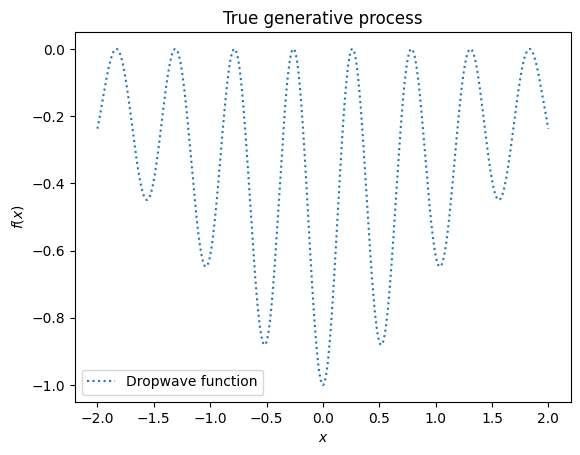

In [644]:
X = np.linspace(start=-2, stop=2, num=1_000).reshape(-1, 1)
y = dropwave_fun(X)

plt.plot(X, y, label=r"Dropwave function", linestyle="dotted")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("True generative process")

In [645]:
rng = np.random.RandomState(1)
training_indices = rng.choice(np.arange(y.size), size=20, replace=False)
X_train, y_train = X[training_indices], y[training_indices]

In [646]:
# fit with simple RBF kernel
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-5, 1e5))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gaussian_process.fit(X_train, y_train)
print(f"kernel: {gaussian_process.kernel_}")
print(f"llh: {gaussian_process.log_marginal_likelihood_value_}")

# predictions for the whole set
mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)
mse_all = mean_squared_error(y, mean_prediction)
r2_all = r2_score(y, mean_prediction)

print(f'r2: {r2_all}')   
print(f'mse: {mse_all}')   

kernel: 0.437**2 * RBF(length_scale=0.157)
llh: 2.55224838718809
r2: 0.6099701771992015
mse: 0.03000328795179017


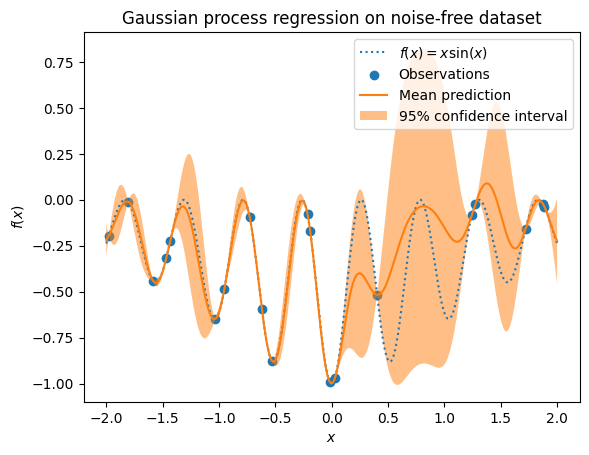

In [647]:
plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.scatter(X_train, y_train, label="Observations")
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on noise-free dataset")

In [648]:
# let's assume we know the kernel shape
kernel = WhiteKernel() \
    + 1 * RBF() * ExpSineSquared()
# fit
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gaussian_process.fit(X_train, y_train)
print(f"kernel: {gaussian_process.kernel_}")
print(f"llh: {gaussian_process.log_marginal_likelihood_value_}")

# predictions for the whole set
mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)
mse_all = mean_squared_error(y, mean_prediction)
r2_all = r2_score(y, mean_prediction)

print(f'r2: {r2_all}')   
print(f'mse: {mse_all}')   

kernel: WhiteKernel(noise_level=1e-05) + 0.43**2 * RBF(length_scale=1.62) * ExpSineSquared(length_scale=1.08, periodicity=1.04)
llh: 10.614697744251743
r2: 0.9759542318931883
mse: 0.0018497357441795296


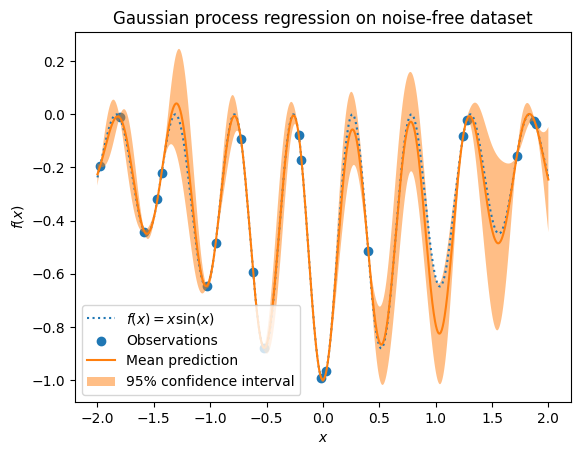

In [649]:
plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.scatter(X_train, y_train, label="Observations")
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on noise-free dataset")

In [251]:
#plt.scatter(y, mean_prediction, label="Predictions vs True Values")
#plt.plot(y,y, 
#         label=r"Ideal", linestyle="dashed")
#plt.legend()
#plt.xlabel("True Value")
#plt.ylabel("Predictions")
#_ = plt.title("Gaussian process regression on noise-free dataset")

In [252]:
#plt.scatter(y, (y-mean_prediction), label="Residuals vs True Values")
#plt.errorbar(y, y-mean_prediction, yerr=(std_prediction,std_prediction), fmt='o', markersize=5, color='blue', ecolor='red', capsize=5, label=r"95% confidence interval")
#plt.legend()
#plt.xlabel("True Value")
#plt.ylabel("Residuals")
#_ = plt.title("Gaussian process regression on noise-free dataset")

In [282]:
# re-instantiate GPR with kernel fixed
gaussian_process = GaussianProcessRegressor(kernel=gaussian_process.kernel_, optimizer=None)

# calculate prediction errors using Mapie
mp_regr = MapieRegressor(gaussian_process, cv=5, method='plus') # method="plus", method not needed if model is prefit
mp_regr.fit(X_train, y_train) 

MapieRegressor(cv=5,
               estimator=GaussianProcessRegressor(kernel=WhiteKernel(noise_level=1e-05) + 0.43**2 * RBF(length_scale=1.62) * ExpSineSquared(length_scale=1.08, periodicity=1.04),
                                                  optimizer=None))

In [283]:
predo, y_pis = mp_regr.predict(pd.DataFrame(X, columns=['X']), alpha=[0.05]) 
predo_lb = y_pis[:,0,:]
predo_ub = y_pis[:,1,:]

r2_train = r2_score(y, predo)

print(f'r2: {r2_train}')

r2: 0.9759542318931883


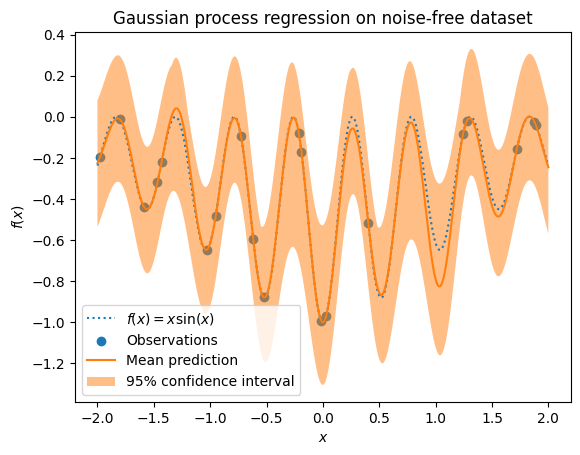

In [284]:
plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.scatter(X_train, y_train, label="Observations")
plt.plot(X, predo, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    predo_lb.ravel(),
    predo_ub.ravel(),
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on noise-free dataset")

In [287]:
# verify kernel is not modified
mp_regr.estimator.kernel

WhiteKernel(noise_level=1e-05) + 0.43**2 * RBF(length_scale=1.62) * ExpSineSquared(length_scale=1.08, periodicity=1.04)

kernel: WhiteKernel(noise_level=1e-05) + 1**2 * RBF(length_scale=0.24) * ExpSineSquared(length_scale=1e+05, periodicity=0.0277)
llh: 326.19073831314654
r2: 0.999999723759458
mse: 2.1249976385749873e-08


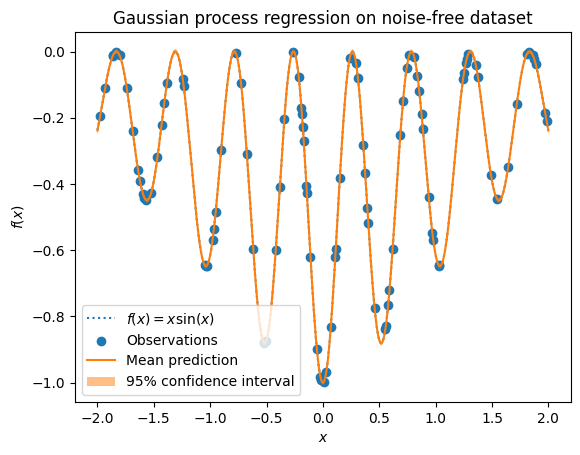

In [288]:
# let's assume we have more data - this becomes slower
rng = np.random.RandomState(1)
training_indices = rng.choice(np.arange(y.size), size=100, replace=False)
X_train, y_train = X[training_indices], y[training_indices]

X_train_df = pd.DataFrame(np.concatenate([X_train, y_train.reshape(-1,1)], axis=1), columns=['X','y'])

kernel = WhiteKernel() \
    + 1 * RBF() * ExpSineSquared()
# fit
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gaussian_process.fit(X_train, y_train)
print(f"kernel: {gaussian_process.kernel_}")
print(f"llh: {gaussian_process.log_marginal_likelihood_value_}")

# predictions for the whole set
mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)
mse_all = mean_squared_error(y, mean_prediction)
r2_all = r2_score(y, mean_prediction)

print(f'r2: {r2_all}')   
print(f'mse: {mse_all}')   

plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.scatter(X_train, y_train, label="Observations")
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on noise-free dataset")

r2: 0.999999723759458


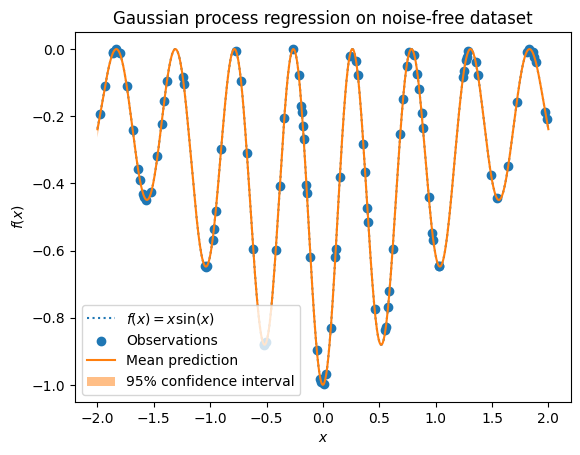

In [289]:
# re-instantiate GPR with kernel fixed
gaussian_process = GaussianProcessRegressor(kernel=gaussian_process.kernel_, optimizer=None)

mp_regr = MapieRegressor(gaussian_process, cv=5, method='plus') 
mp_regr.fit(X_train, y_train) 

predo, y_pis = mp_regr.predict(pd.DataFrame(X, columns=['X']), alpha=[0.05]) 
predo_lb = y_pis[:,0,:]
predo_ub = y_pis[:,1,:]

r2_train = r2_score(y, predo)

print(f'r2: {r2_train}')

plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.scatter(X_train, y_train, label="Observations")
plt.plot(X, predo, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    predo_lb.ravel(),
    predo_ub.ravel(),
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on noise-free dataset")

In [292]:
mp_regr.estimator.kernel

WhiteKernel(noise_level=1e-05) + 1**2 * RBF(length_scale=0.24) * ExpSineSquared(length_scale=1e+05, periodicity=0.0277)

In [294]:
# all above  in one function

from polygp_optuna_1 import *

rng = np.random.RandomState(1)
training_indices = rng.choice(np.arange(y.size), size=20, replace=False)
X_train, y_train = X[training_indices], y[training_indices]

# polygp_optuna_1: 
# 1. fits on all data to find best kernel
# 2. fix kernel and its parameter values
# 3. fit Mapie regressor to find CV errors 

X_train_df = pd.DataFrame(np.concatenate([X_train, y_train.reshape(-1,1)], axis=1), columns=['X','y'])

ppl_best, _, krnl_best, _ = train_polygp(X_train_df,
                                    ['X'], 
                                    ['y'],
                                    [], 
                                    ['X'],
                                    max_evals=1000, early_stopping_rounds=200)


2023-10-30 15:18:01,901 - SEQEX DEBUG - train_polygp - Running kernel optimization


  0%|          | 0/1000 [00:00<?, ?it/s]

2023-10-30 15:22:37,792 - SEQEX DEBUG - Duplicated trial: {'n_sel_kernels_opt': 1, 'comb_kern_idx_opt': 4, 'n_prod_opt': 1, 'n_terms_opt': 1, 'comb_terms_idx_opt': 1}, return 6.89912682255107
2023-10-30 15:25:14,199 - SEQEX DEBUG - early stopping detected: True
2023-10-30 15:25:14,222 - SEQEX DEBUG - train_polygp - Best trial: FrozenTrial(number=54, state=TrialState.COMPLETE, values=[-28.200667219849198], datetime_start=datetime.datetime(2023, 10, 30, 15, 19, 10, 575098), datetime_complete=datetime.datetime(2023, 10, 30, 15, 19, 11, 685595), params={'n_sel_kernels_opt': 18, 'comb_kern_idx_opt': 10331, 'n_prod_opt': 2, 'n_terms_opt': 2, 'comb_terms_idx_opt': 2697}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_sel_kernels_opt': IntDistribution(high=23, log=False, low=1, step=1), 'comb_kern_idx_opt': IntDistribution(high=33649, log=False, low=1, step=1), 'n_prod_opt': IntDistribution(high=3, log=False, low=1, step=1), 'n_terms_opt': IntDistribution(high=5, log

In [295]:
str(krnl_best).split(' + ')

['WhiteKernel(noise_level=1e-05)',
 '0.149**2 * ExpSineSquared(length_scale=15.2, periodicity=0.558) ** 2',
 '0.672**2 * RationalQuadratic(alpha=1.3e+04, length_scale=2.44) ** 3 * ExpSineSquared(length_scale=6.56, periodicity=0.427) ** 2']

In [296]:
predo, y_pis = ppl_best.predict(pd.DataFrame(X, columns=['X']), alpha=[0.05]) 
predo_lb = y_pis[:,0,:]
predo_ub = y_pis[:,1,:]

r2_train = r2_score(y, predo)

print(f'r2: {r2_train}')

r2: 0.9930482581744433


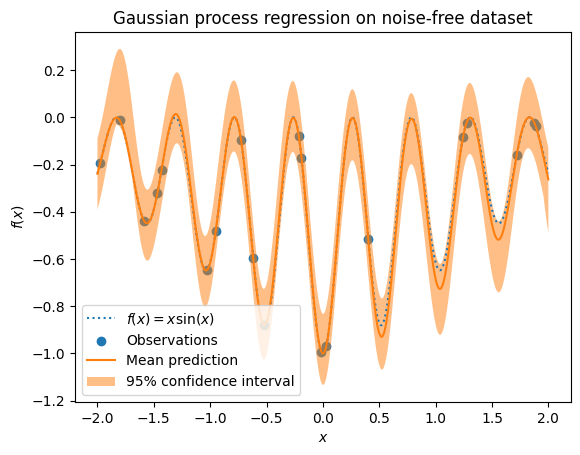

In [297]:
plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.scatter(X_train, y_train, label="Observations")
plt.plot(X, predo, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    predo_lb.ravel(),
    predo_ub.ravel(),
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on noise-free dataset")

In [298]:
def average_coverage_error(y_true, lower_bounds, upper_bounds):
    """
    Calculate the Average Coverage Error (ACE) for prediction intervals.
    It represents how much the interval can be trusted, because, for example, 
    when we say that we compute the 90 % confidence interval, we want that close to 90% of the test points 
    rely in that interval. For this reason we usually refer to that metric as measuring the reliability of the interval.    

    Parameters:
    - y_true: Array of true target values.
    - lower_bounds: Array of lower bounds for prediction intervals.
    - upper_bounds: Array of upper bounds for prediction intervals.

    Returns:
    - ACE: The Average Coverage Error.
    """
    # Ensure all input arrays have the same shape
    assert len(y_true) == len(lower_bounds) == len(upper_bounds)

    # Calculate the coverage error for each data point
    coverage_errors = (y_true <= upper_bounds) & (y_true >= lower_bounds)

    # Calculate the Average Coverage Error
    ACE = np.mean(coverage_errors)

    return ACE


def prediction_interval_normalized_average_width(y_true, lower_bounds, upper_bounds):
    """
    Calculate the Prediction Interval Normalized Average Width (PINAW).

    Parameters:
    y_true: array-like
        The true target values.
    prediction_intervals: list of arrays
        List of prediction intervals for each data point.
        Each prediction interval should be an array of shape (n_intervals, 2),
        where n_intervals is the number of intervals for the corresponding data point.

    Returns:
    pinaw: float
        The Prediction Interval Normalized Average Width.
    """

    widths = upper_bounds - lower_bounds
    target_range = max(y_true) - min(y_true)    

    # Calculate the average normalized width
    pinaw = sum(widths) / (target_range * len(y_true))
    return pinaw


In [299]:
# The wider the intervals the higher will be the coverage. 
# So, higher coverage may lead to a higher PINAW or reduced
# sharpness and vice-versa.   
print(f'ACE: {average_coverage_error(mean_prediction, predo_lb, predo_ub)}')        
print(f'PINRW: {prediction_interval_normalized_average_width(mean_prediction, predo_lb, predo_ub)}')        


ACE: 0.308495
PINRW: [0.30236189]


2023-10-30 15:59:59,100 - SEQEX DEBUG - train_polygp - Running kernel optimization


  0%|          | 0/1000 [00:00<?, ?it/s]

2023-10-30 15:59:59,693 - SEQEX ERROR - An error occurred: ("The kernel, WhiteKernel(noise_level=7.65e+04) + 0.00357**2 * DotProduct(sigma_0=5.11) ** 3 + 202**2 * RBF(length_scale=3.38e+04) * DotProduct(sigma_0=9.57) ** 3 + 117**2 * DotProduct(sigma_0=1.31e+04) ** 3 * DotProduct(sigma_0=4.45e+03) ** 3 + 0.00748**2 * Matern(length_scale=7.07e+04, nu=1.5) ** 2 * ExpSineSquared(length_scale=2.53e-05, periodicity=6.19e+04) ** 1.5, is not returning a positive definite matrix. Try gradually increasing the 'alpha' parameter of your GaussianProcessRegressor estimator.", '6-th leading minor of the array is not positive definite')
2023-10-30 16:00:02,601 - SEQEX ERROR - An error occurred: ("The kernel, WhiteKernel(noise_level=0.124) + 0.14**2 * DotProduct(sigma_0=8.59e+04) ** 2 + 1.11**2 * RBF(length_scale=672) * Matern(length_scale=55.4, nu=2.5) ** 3, is not returning a positive definite matrix. Try gradually increasing the 'alpha' parameter of your GaussianProcessRegressor estimator.", '4-th l

['WhiteKernel(noise_level=0.0728)',
 '0.52**2 * RBF(length_scale=1.77) * RBF(length_scale=3.84e+03) ** 0.5']

r2: 0.13061335940937757


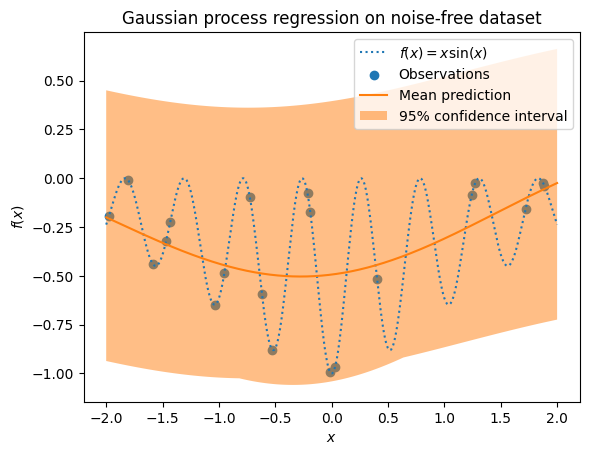

In [307]:
# running faster by generating hyperparameter values as well
from polygp_optuna import *

rng = np.random.RandomState(1)
training_indices = rng.choice(np.arange(y.size), size=20, replace=False)
X_train, y_train = X[training_indices], y[training_indices]

X_train_df = pd.DataFrame(np.concatenate([X_train, y_train.reshape(-1,1)], axis=1), columns=['X','y'])

ppl_best, _, krnl_best, _ = train_polygp(X_train_df,
                                    ['X'], 
                                    ['y'],
                                    [], 
                                    ['X'],
                                    max_evals=1000, early_stopping_rounds=200)

display(str(krnl_best).split(' + '))

predo, y_pis = ppl_best.predict(pd.DataFrame(X, columns=['X']), alpha=[0.05]) 
predo_lb = y_pis[:,0,:]
predo_ub = y_pis[:,1,:]

r2_train = r2_score(y, predo)

print(f'r2: {r2_train}')

plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.scatter(X_train, y_train, label="Observations")
plt.plot(X, predo, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    predo_lb.ravel(),
    predo_ub.ravel(),
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on noise-free dataset")

2D testing

In [578]:
from kerner_nonstationary import *

In [815]:
import plotly.graph_objs as go

# Create a contour plot
contour_plot = go.Contour(
    x=X_train[:,0],  # X values
    y=X_train[:,1],  # Y values
    z=Z_train.ravel(),  # Z values
    colorscale='Viridis',  # Choose a colorscale
    colorbar=dict(title='Z Values'),  # Colorbar title
)

# Create a figure and add the contour plot
fig = go.Figure(data=[contour_plot])

# Set axis labels
fig.update_layout(
    xaxis=dict(title='X-axis'),
    yaxis=dict(title='Y-axis'),
    title='Contour Plot',
)

# Show the plot
fig.show()

In [867]:
import plotly.graph_objects as go
from sklearn.preprocessing import PolynomialFeatures

X1 = np.linspace(start=-2, stop=2, num=50)
X2 = np.linspace(start=-2, stop=2, num=50)
X1, X2 = np.meshgrid(X1, X2)
z = -(1 + np.cos(12*np.sqrt(X1**2+X2**2)))/(0.5*(X1**2+X2**2)+2)

X = np.column_stack((X1.reshape(-1), X2.reshape(-1)))
Z = z.reshape(-1,1)

rng = np.random.RandomState(1)
training_indices = rng.choice(np.arange(Z.shape[0]), size=20, replace=False)
X_train, Z_train = X[training_indices], Z[training_indices]

# let's assume we know there is circular symmetry
xy_fun = lambda xy: np.sqrt(np.square(xy).sum(axis=1)).reshape(-1,1)


# let's assume we know the kernel shape
#kernel =  1 * Matern(length_scale=[1,1]) 
#kernel = ConstantKernel(1.0, (0.01, 100)) \
#    * ManifoldKernel.construct(base_kernel=RBF(1, [(1e-5, 1e5)]), architecture=((1, 2, 3),(1,2, 3)),
#                               transfer_fct="tanh", max_nn_weight=1)
# Gaussian Process with Manifold kernel (using an isotropic RBF kernel on
# manifold for learning the target function)
# Use an MLP with 3 hidden-layer for the mapping from data space to manifold
#architecture=((1, 2, 1),(1, 2, 1)) # n features, n hidden, n_dim_manifold for each input
#kernel = ConstantKernel(1.0, (1e-10, 100)) \
#    * ManifoldKernel.construct(base_kernel=RBF(0.1, (1e-5, 1e5)),
#                               architecture=architecture,
#                               transfer_fct="relu", max_nn_weight=3.0) \
#    + WhiteKernel(1e-3, (1e-10, 1e-1))

#kernel = ConstantKernel(1.0, (1e-10, 1000)) \
#  * LocalLengthScalesKernel.construct(X_train, l_L=0.01, l_U=0.1, l_samples=5)

#kernel = WhiteKernel() \
#    + 1 * RBF((1,1), [(1e9,1e9),(1e-5,1e5)]) * ExpSineSquared() * RBF((1,1), [(1e-5,1e5),(1e9,1e9)])

kernel = WhiteKernel() \
    + 1 * RBF() * ExpSineSquared()

# fit
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=False)
gaussian_process.fit(xy_fun(X_train), Z_train) 
print(f"kernel: {gaussian_process.kernel_}")
print(f"llh: {gaussian_process.log_marginal_likelihood_value_}")

# predictions for the whole set
mean_prediction, std_prediction = gaussian_process.predict(xy_fun(X), return_std=True)
mse_all = mean_squared_error(Z, mean_prediction)
r2_all = r2_score(Z, mean_prediction)

print(f'r2: {r2_all}')   
print(f'mse: {mse_all}')

# Create a 2D surface plot
fig = go.Figure(data=[go.Surface(z=z, x=X1, y=X2)])

# Set the layout
fig.update_layout(
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='Z Axis',
    )
)

# Show the plot
fig.show()

kernel: WhiteKernel(noise_level=1e-05) + 1.72**2 * RBF(length_scale=5) * ExpSineSquared(length_scale=7.47, periodicity=0.524)
llh: 50.27406885633786
r2: 0.9978960679769311
mse: 0.00012366203186105922


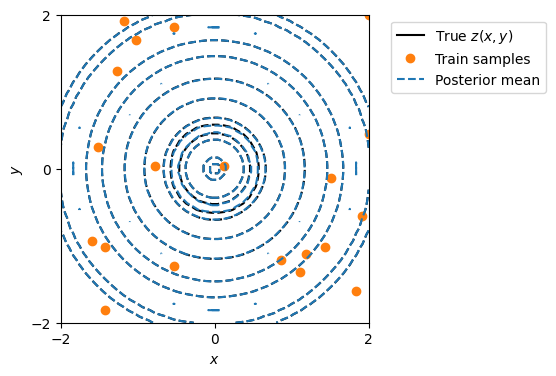

In [824]:
import matplotlib.lines as mlines

# Set up figure
fig, ax = plt.subplots(figsize=(6., 4.))
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_xlim((-2,2))
ax.set_ylim((-2,2))
ax.set_aspect('equal')
ax.set_xticks((-2,0,2))
ax.set_yticks((-2,0,2))
ax.grid(False)

# Do the plotting
lev = np.linspace(-2.,0.,6)
ax.contour(X1, X2, z, lev,colors='k')  # Truth
ax.plot(*X_train.T, 'o',color="C1")  # Training samples
ax.contour(X1, X2, mean_prediction.reshape(X1.shape), lev, colors='C0', linestyles='dashed')  # Posterior mean

# Legend
truth_line = mlines.Line2D([], [], color='black', label='True $z(x,y)$')
sample_line = mlines.Line2D([], [], color='C1', marker="o", linestyle="none", label='Train samples')
mean_line = mlines.Line2D([], [], color='C0', linestyle="--", label='Posterior mean')
ax.legend(handles=[truth_line, sample_line, mean_line],bbox_to_anchor=(1.05, 1), loc="upper left")


2023-11-02 12:14:01,985 - SEQEX DEBUG - locator: <matplotlib.ticker.FixedLocator object at 0x29645b370>


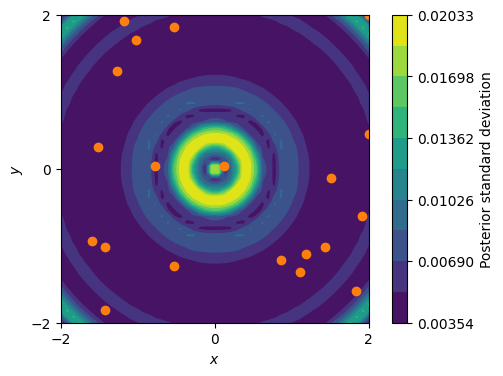

In [825]:
fig, ax = plt.subplots(figsize=(6., 4.))
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_xlim((-2,2))
ax.set_ylim((-2,2))
ax.set_aspect('equal')
ax.set_xticks((-2,0,2))
ax.set_yticks((-2,0,2))
ax.grid(False)

# Do the plotting
ax.plot(*X_train.T,'o',color="C1")  # Training samples
lev = np.linspace(min(std_prediction),max(std_prediction),11)
hc = ax.contourf(X1, X2, std_prediction.reshape(X1.shape), lev)  # Posterior std
for hci in hc.collections:
  hci.set_edgecolor("face")

# Colorbar
hcb = plt.colorbar(hc)
hcb.ax.grid(False)
hcb.set_label('Posterior standard deviation')


In [719]:
## 2d - all together

from polygp_optuna_1 import *

X1 = np.linspace(start=-2, stop=2, num=50)
X2 = np.linspace(start=-2, stop=2, num=50)
X1, X2 = np.meshgrid(X1, X2)
z = -(1 + np.cos(12*np.sqrt(X1**2+X2**2)))/(0.5*(X1**2+X2**2)+2)

X = np.column_stack((X1.reshape(-1), X2.reshape(-1)))
Z = z.reshape(-1,1)

rng = np.random.RandomState(1)
training_indices = rng.choice(np.arange(Z.shape[0]), size=20, replace=False)
X_train, Z_train = X[training_indices], Z[training_indices]

X_train_df = pd.DataFrame(np.concatenate([X_train, Z_train.reshape(-1,1)], axis=1), columns=['X1','X2', 'y'])

ppl_best, _, krnl_best, _ = train_polygp(X_train_df,
                                    ['X1','X2'], 
                                    ['y'],
                                    [], 
                                    ['X1','X2'],
                                    max_evals=1000, early_stopping_rounds=200)


2023-11-01 13:59:56,399 - SEQEX DEBUG - train_polygp - Running kernel optimization


  0%|          | 0/1000 [00:00<?, ?it/s]

2023-11-01 14:00:39,123 - SEQEX DEBUG - Duplicated trial: {'n_sel_kernels_opt': 1, 'comb_kern_idx_opt': 1, 'n_prod_opt': 2, 'n_terms_opt': 1, 'comb_terms_idx_opt': 1}, return 5.734177057662778
2023-11-01 14:00:48,495 - SEQEX DEBUG - Duplicated trial: {'n_sel_kernels_opt': 1, 'comb_kern_idx_opt': 6, 'n_prod_opt': 2, 'n_terms_opt': 1, 'comb_terms_idx_opt': 1}, return 5.7341770576627855
2023-11-01 14:00:48,559 - SEQEX DEBUG - Duplicated trial: {'n_sel_kernels_opt': 1, 'comb_kern_idx_opt': 7, 'n_prod_opt': 2, 'n_terms_opt': 1, 'comb_terms_idx_opt': 1}, return 5.734177057663112
2023-11-01 14:01:04,814 - SEQEX DEBUG - Duplicated trial: {'n_sel_kernels_opt': 1, 'comb_kern_idx_opt': 5, 'n_prod_opt': 2, 'n_terms_opt': 1, 'comb_terms_idx_opt': 1}, return 8.905146532190573
2023-11-01 14:01:04,876 - SEQEX DEBUG - Duplicated trial: {'n_sel_kernels_opt': 1, 'comb_kern_idx_opt': 7, 'n_prod_opt': 2, 'n_terms_opt': 1, 'comb_terms_idx_opt': 1}, return 5.734177057663112
2023-11-01 14:01:09,606 - SEQEX DE

In [720]:
str(krnl_best).split(' + ')

['WhiteKernel(noise_level=0.033)', '0.207**2 * RBF(length_scale=1.52)']

In [722]:
predo, y_pis = ppl_best.predict(pd.DataFrame(X, columns=['X1','X2']), alpha=[0.05]) 
predo_lb = y_pis[:,0,:]
predo_ub = y_pis[:,1,:]

r2_train = r2_score(Z, predo)

print(f'r2: {r2_train}')

r2: -0.12087698714862238


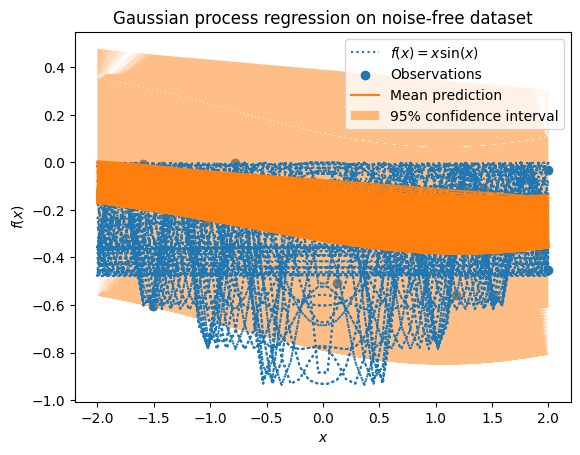

In [723]:
# Replace with plot contour
idx = 0
plt.plot(X[:,idx], Z, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.scatter(X_train[:,idx], Z_train, label="Observations")
plt.plot(X[:,idx], predo, label="Mean prediction")
plt.fill_between(
    X[:,idx].ravel(),
    predo_lb.ravel(),
    predo_ub.ravel(),
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on noise-free dataset")

In [216]:
# let's use more data
rng = np.random.RandomState(1)
training_indices = rng.choice(np.arange(y.size), size=100, replace=False)
X_train, y_train = X[training_indices], y[training_indices]

X_train_df = pd.DataFrame(np.concatenate([X_train, y_train.reshape(-1,1)], axis=1), columns=['X','y'])

ppl_best, _, krnl_best, _ = train_polygp(X_train_df,
                                    ['X'], 
                                    ['y'],
                                    [], 
                                    ['X'],
                                    max_evals=1000, early_stopping_rounds=200)


2023-10-30 09:34:22,737 - SEQEX DEBUG - train_polygp - Running kernel optimization


  0%|          | 0/1000 [00:00<?, ?it/s]

2023-10-30 09:57:39,683 - SEQEX DEBUG - Duplicated trial: {'n_sel_kernels_opt': 23, 'comb_kern_idx_opt': 1, 'n_prod_opt': 1, 'n_terms_opt': 1, 'comb_terms_idx_opt': 16}, return -633.9604439963202
2023-10-30 10:12:10,953 - SEQEX DEBUG - Duplicated trial: {'n_sel_kernels_opt': 23, 'comb_kern_idx_opt': 1, 'n_prod_opt': 2, 'n_terms_opt': 1, 'comb_terms_idx_opt': 181}, return -633.8159240535532


KeyboardInterrupt: 

Best kernel: WhiteKernel(noise_level=1e-05) + 0.467**2 * ExpSineSquared(length_scale=0.000154, periodicity=6.54e+03) * Matern(length_scale=3.95e+04, nu=1.5) ** 3
llh: -0.9696654191151701
r2: 0.9999999528493018, 0.8527485724890445
mse: 4.441965510348286e-09, 0.017870569046891726
ACE: 1.0, 1.0
PINRW: 0.017850447270564267, 0.49082237557261316


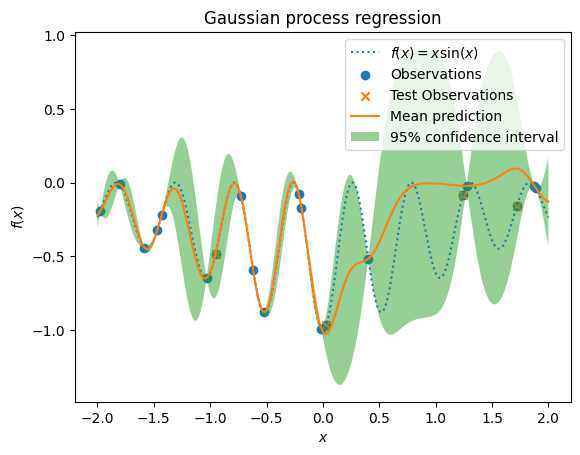

Best kernel: WhiteKernel(noise_level=1e-05) + 0.427**2 * ExpSineSquared(length_scale=0.00274, periodicity=343) * Matern(length_scale=9.97e+04, nu=1.5) ** 3
llh: -3.392980186660168
r2: 0.9999999679346269, 0.9514752163246616
mse: 2.321252779509435e-09, 0.008734500881742782
ACE: 1.0, 1.0
PINRW: 0.018332081763346282, 0.41874516596259026


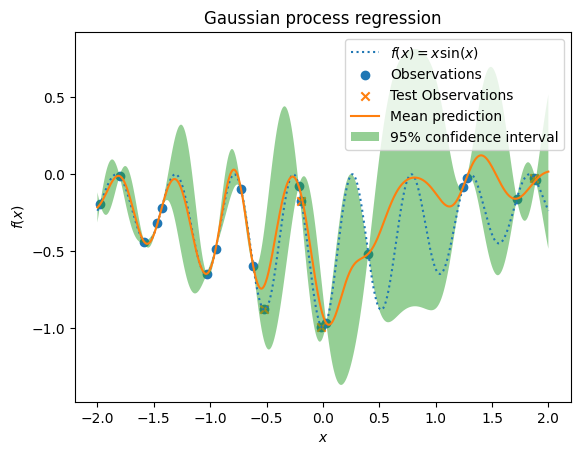

Best kernel: WhiteKernel(noise_level=1e-05) + 0.443**2 * ExpSineSquared(length_scale=7.99e-05, periodicity=1.15e+04) * Matern(length_scale=2.27e+04, nu=1.5) ** 3
llh: -0.2911312895655822
r2: 0.999999831076822, 0.6746850936028437
mse: 1.838714596065629e-08, 0.02267042024975148
ACE: 1.0, 1.0
PINRW: 0.017847218236971957, 1.3258968391705306


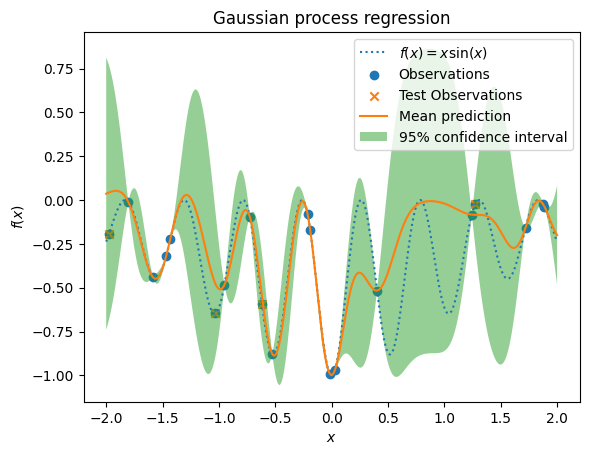

Best kernel: WhiteKernel(noise_level=1e-05) + 0.46**2 * ExpSineSquared(length_scale=0.000139, periodicity=6.76e+03) * Matern(length_scale=8.12e+04, nu=1.5) ** 3
llh: -1.8632148165539313
r2: 0.9999998321322608, 0.052419562117548724
mse: 1.8724034437110608e-08, 0.013741639782753317
ACE: 1.0, 1.0
PINRW: 0.018055538385423436, 4.157849636608671


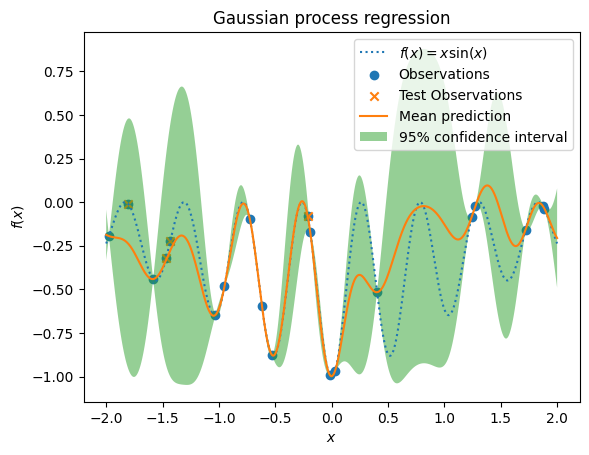

Best kernel: WhiteKernel(noise_level=1e-05) + 0.43**2 * ExpSineSquared(length_scale=0.000102, periodicity=9.07e+03) * Matern(length_scale=8.5e+04, nu=1.5) ** 3
llh: -0.6963917771312786
r2: 0.9999999695196605, -0.5423872261429672
mse: 3.4664488363386165e-09, 0.0673338706459434
ACE: 1.0, 1.0
PINRW: 0.017855312565779317, 1.953501758801787


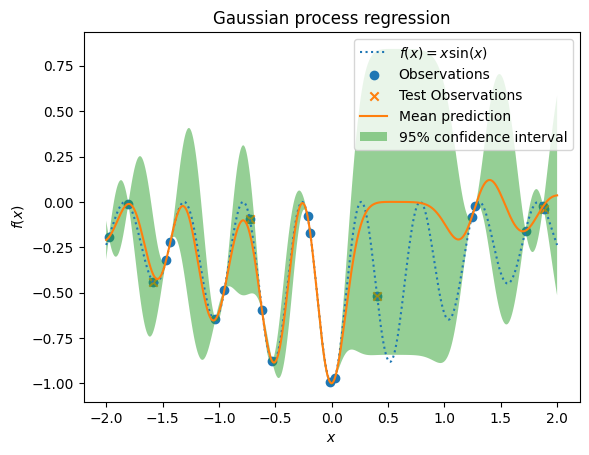

In [106]:
from sklearn.model_selection import RepeatedKFold

df_len = len(X_train) # if 4 or below n_test_fold == 0, up to 10 LOOCV, more than 10 CV=5
n_test_fold = int(0.2*df_len)
n_splits = int(df_len/n_test_fold)
n_repeats = 1
if n_splits == df_len:
    n_repeats = 1
cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats)

for train_index, val_index in cv.split(X_train):
    #kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
    kernel = WhiteKernel(noise_level=1e-05) + 0.399**2 * ExpSineSquared(length_scale=2.37, periodicity=0.43) * Matern(length_scale=4.58, nu=1.5) ** 3
    gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
    gaussian_process.fit(X_train[train_index], y_train[train_index])
    y_train_pred, y_train_std = gaussian_process.predict(X_train[train_index], return_std=True)
    y_test_pred, y_test_std = gaussian_process.predict(X_train[val_index], return_std=True)
    y_train_pred_l = y_train_pred - 1.96*y_train_std
    y_train_pred_u = y_train_pred + 1.96*y_train_std
    y_test_pred_l = y_test_pred - 1.96*y_test_std
    y_test_pred_u = y_test_pred + 1.96*y_test_std

    r2_train = r2_score(y_train[train_index], y_train_pred)
    r2_test = r2_score(y_train[val_index], y_test_pred)

    print(f"Best kernel: {str(gaussian_process.kernel_)}")
    print(f"llh: {gaussian_process.log_marginal_likelihood_value_}")
    print(f'r2: {r2_train}, {r2_test}')   
    mse_train = mean_squared_error(y_train[train_index], y_train_pred)
    mse_test = mean_squared_error(y_train[val_index], y_test_pred)
    print(f'mse: {mse_train}, {mse_test}')   
    # The wider the intervals the higher will be the coverage. 
    # So, higher coverage may lead to a higher PINAW or reduced
    # sharpness and vice-versa.   
    print(f'ACE: {average_coverage_error(y_train_pred, y_train_pred_l, y_train_pred_u)}, {average_coverage_error(y_test_pred, y_test_pred_l, y_test_pred_u)}')        
    print(f'PINRW: {prediction_interval_normalized_average_width(y_train_pred, y_train_pred_l, y_train_pred_u)}, {prediction_interval_normalized_average_width(y_test_pred, y_test_pred_l, y_test_pred_u)}')        

    mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)

    plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
    plt.scatter(X_train, y_train, label="Observations")
    plt.scatter(X_train[val_index], y_train[val_index], marker = 'x', label="Test Observations")
    plt.plot(X, mean_prediction, label="Mean prediction")
    plt.fill_between(
        X.ravel(),
        mean_prediction - 1.96 * std_prediction,
        mean_prediction + 1.96 * std_prediction,
        alpha=0.5,
        label=r"95% confidence interval",
    )
    plt.legend()
    plt.xlabel("$x$")
    plt.ylabel("$f(x)$")
    _ = plt.title(f"Gaussian process regression") #k: {str(gaussian_process.kernel_)}
    plt.show()